<a href="https://colab.research.google.com/github/monicasjsu/Machine_Learning/blob/main/AlternusVera_Sprint2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Team**: **SheCodes**

**Team Members and Contribution**: 
1. Asha Aher : Misleading Intentions
2. Monica Dommaraju : Text and Body
3. Sri Sruthi Chilukuri : Content Statistics
4. Swati Narkhede : Writing Style




**Alternus Vera Part2**

 The sources for news have become so many from online news and social media to news articles and newspapers.In this work, we as a team would like to put forward a machine learning model to make a prediction on the fake news and differentiate it from the real news based on various aspects. The data has been collected from kaggle and other sources which contained texts along with the speakers and authors; giving us good scope to build a separate model that can classify the truthful news content from the fake news. 

Datasets used: 
1. Kaggle Fake News Dataset
2. Liar-Liar Dataset
3. politifact news Dataset


# Data Loading and Pre Processing

In [ ]:
import pandas as pd
import numpy as np
import csv
import re
import seaborn as sns
from google.colab import drive
import gensim
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
drive.mount('/content/drive')
# Load Fake News dataset from Kaggle
fake_train = pd.read_csv("/content/drive/Shared drives/SheCodes/Datasets/fakenews/train_fakenews.csv",sep=',')
fake_test = pd.read_csv("/content/drive/Shared drives/SheCodes/Datasets/fakenews/test_fakenews.csv",sep=',')
fake_submit = pd.read_csv("/content/drive/Shared drives/SheCodes/Datasets/fakenews/submit_fakenews.csv",sep=',')
fake_test = pd.merge(fake_test, fake_submit, on="id", how='left')
fake_train.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
fake_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
fake_test.head()


,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


In [ ]:
fake_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
 4   label   5200 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 243.8+ KB


In [ ]:
df_kaggle = pd.concat([fake_train, fake_test])
df_kaggle.shape
# Pick only title and text columns from Kaggle dataset
df_final = df_kaggle[['title', 'text', 'label']]
df_final.shape

(26000, 3)

In [ ]:
# Load Liar-Liar dataset
columns = [
  'jsonid', 
  'label', 
  'text', 
  'subject', 
  'speaker', 
  'speakerjobtitle', 
  'stateinfo',
  'partyaffiliation', 
  'barelytruecounts', 
  'falsecounts',
  'halftruecounts',
  'mostlytrueocunts',
  'pantsonfirecounts',
  'context'
  ]
liar_train = pd.read_csv("/content/drive/Shared drives/SheCodes/Datasets/liar_dataset/train.tsv",sep='\t', names=columns)
liar_test = pd.read_csv("/content/drive/Shared drives/SheCodes/Datasets/liar_dataset/test.tsv",sep='\t', names=columns)
liar_valid = pd.read_csv("/content/drive/Shared drives/SheCodes/Datasets/liar_dataset/valid.tsv",sep='\t', names=columns)

In [ ]:
liar_train.head()

,jsonid,label,text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


As we can see above, there is no body feature in the Liar-Liar dataset. So we are going to leave this dataset for title vs body factor analysis

In [ ]:
liar_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   jsonid             10240 non-null  object 
 1   label              10240 non-null  object 
 2   text               10240 non-null  object 
 3   subject            10238 non-null  object 
 4   speaker            10238 non-null  object 
 5   speakerjobtitle    7343 non-null   object 
 6   stateinfo          8032 non-null   object 
 7   partyaffiliation   10238 non-null  object 
 8   barelytruecounts   10238 non-null  float64
 9   falsecounts        10238 non-null  float64
 10  halftruecounts     10238 non-null  float64
 11  mostlytrueocunts   10238 non-null  float64
 12  pantsonfirecounts  10238 non-null  float64
 13  context            10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


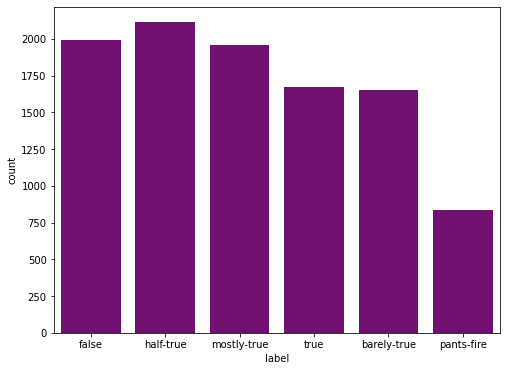

In [ ]:
plt.figure(figsize=(8,6))
p=sns.countplot(liar_train["label"], color='purple')

We can see that in liar train dataset, half true news are more as compared to other category of news.

For a better classification; we combine the labels in the following way:

* "False", "half-true", "barely-true", "pants-fire" as lies i.e. class 0
* "True" & "mostly-true" as truth i.e. class 1

In [ ]:
cat_to_nums = {"label":     {"true":1, "false":0, "barely-true": 0, "half-true": 0, "mostly-true": 1,"pants-fire": 0} }
liar_train.replace(cat_to_nums, inplace=True)
liar_train['label']


0        0
1        0
2        1
3        0
4        0
        ..
10235    1
10236    1
10237    0
10238    0
10239    0
Name: label, Length: 10240, dtype: int64

143

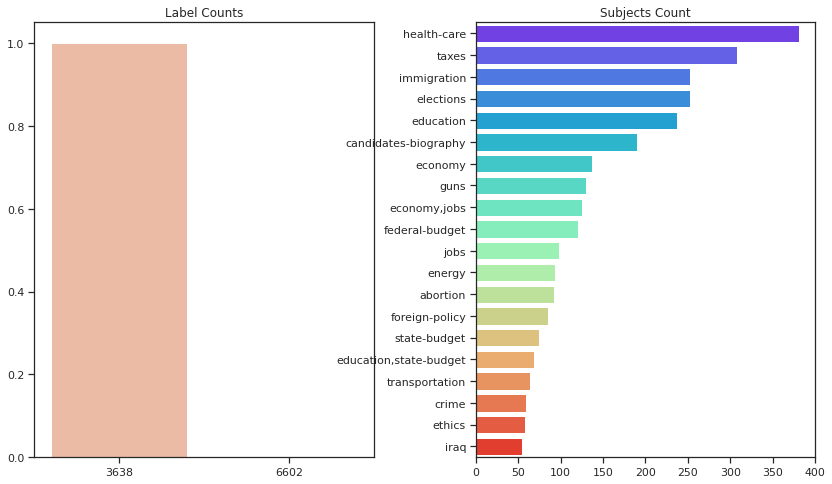

In [ ]:
import gc
import matplotlib.pyplot as matplot_plt
import seaborn as seaborn_lib; seaborn_lib.set(style="ticks", color_codes=True)
f,ax = matplot_plt.subplots(1,2, figsize=(14,8))
ax1,ax2, = ax.flatten()
cnt = liar_train['label'].value_counts()[:20].to_frame()

seaborn_lib.barplot(cnt['label'], cnt.index, palette = 'RdBu', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Label Counts')

cnt = liar_train['subject'].value_counts()[:20].to_frame()

seaborn_lib.barplot(cnt['subject'], cnt.index, palette = 'rainbow', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Subjects Count')
matplot_plt.subplots_adjust(wspace=0.3)
gc.collect()

In [ ]:
# Load Politifact news dataset
politifact_fake = pd.read_csv("/content/drive/Shared drives/SheCodes/Datasets/poitifact_dataset/Fake.csv",sep=',')
politifact_fake['label'] = 1
politifact_true = pd.read_csv("/content/drive/Shared drives/SheCodes/Datasets/poitifact_dataset/True.csv",sep=',')
politifact_true['label'] = 0
df_politifact = pd.concat([politifact_fake, politifact_true])
df_politifact.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [ ]:

df_politifact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [ ]:
df_final = df_final.append(df_politifact[['title', 'text', 'label']])
df_final = df_final.sample(frac=1).reset_index(drop=True)
df_final.head()

,title,text,label
0,Trump Continues To Solicit Illegal Donations ...,"Foreign nationals, including lawmakers and oth...",1
1,"Donald Trump’s Secret Weapon: Letters of Love,...","In one letter, Donald J. Trump ranted about th...",0
2,"Preaching the Gospel of Diversity, but Not Fol...",ONLY two of the reporters who covered the pr...,0
3,What Ann Coulter Just Called Fox News And Ted...,This one has to be seen to be believed.Liberal...,1
4,"David Friedman, Choice for Envoy to Israel, Is...",JERUSALEM — He is president of the American...,0


In [ ]:
df_final['title'] = df_final['title'].astype('str')
df_final['text'] = df_final['text'].astype('str')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70898 entries, 0 to 70897
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   70898 non-null  object
 1   text    70898 non-null  object
 2   label   70898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


# Text Cleaning

In this section, we are going to clean the tile and text string by performing the following text cleaning operations
* Lower case text
* Remove special characters
* Tokenize text into words using nltk
* Remove stop Words
* Lemmatization and Stemming

In [ ]:
import re
import time
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Remove this line when you want to run this for complete dataset
df_final = df_final.truncate(after=10000)

def text_cleaning(text):
  lemmatizer = WordNetLemmatizer()
  clean_text = re.sub("[^a-zA-Z]", " ", text)
  lowered_text = clean_text.lower()
  words = nltk.word_tokenize(lowered_text)
  # All stop words
  stop_words = set(nltk.corpus.stopwords.words("english"))
  filtered_words = [word for word in  words  if not word in stop_words]
  lemm_words = [lemmatizer.lemmatize(word) for word in filtered_words]
  stems = [SnowballStemmer('english').stem(word) for word in lemm_words]
  return " ".join(stems)

t1 = time.time()
df_final["title"] = df_final["title"].apply(text_cleaning)
df_final["text"] = df_final["text"].apply(text_cleaning)
t2 = time.time()
print("Time take for text cleaning with length: {} is {} mins".format(len(df_final), (t2-t1)/60))
df_final.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Time take for text cleaning with length: 10001 is 1.624888288974762 mins


,title,text,label
0,trump continu solicit illeg donat foreign lawmak,foreign nation includ lawmak polit type legal ...,1
1,donald trump secret weapon letter love flatter...,one letter donald j trump rant crisi unsight h...,0
2,preach gospel divers follow new york time,two report cover presidenti campaign new york ...,0
3,ann coulter call fox news ted cruz take gop ci...,one seen believ liber longer accus fox news te...,1
4,david friedman choic envoy israel hostil two s...,jerusalem presid american arm yeshiva settleme...,0


In [ ]:
merged_data = df_final
df = df_final

# Visualizations


**Word clouds**

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_wordcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    

**plotting word cloud for titles**

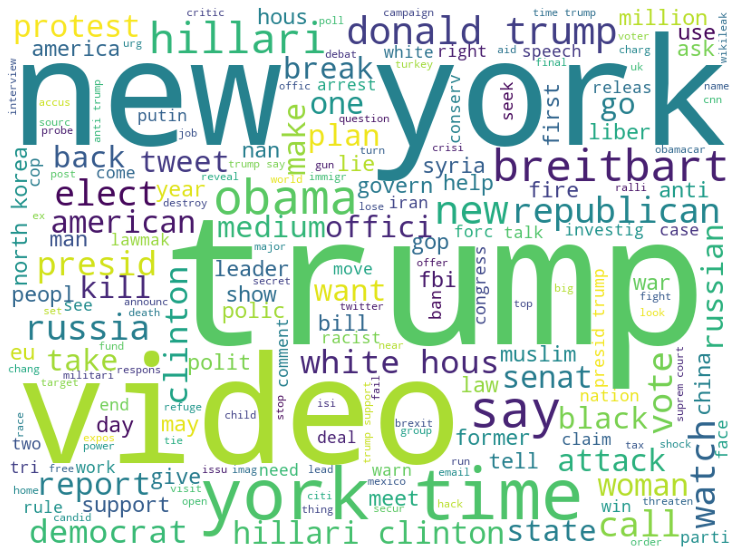

In [ ]:
plot_wordcloud(' '.join(df_final['title']))

**plotting word cloud for text**

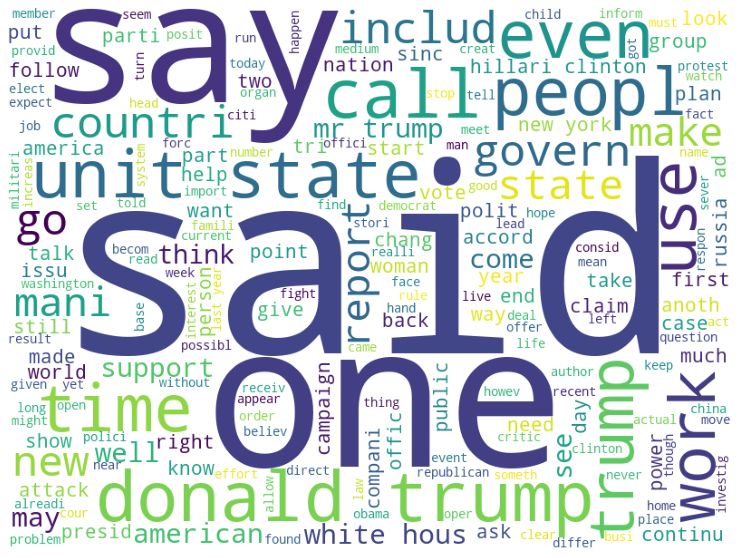

In [ ]:
plot_wordcloud(' '.join(df_final['text']))

# Factor 1: Title Vs Body 
**Name: Monica Dommaraju**


The main idea of Title vs Body factor analysis is to pick Title and text features for each of these three datasets 
1. Kaggle Fake News Dataset
2. Liar-Liar Dataset
3. politifact news Dataset

and perform the following steps
* Amalgamate all three datasets
* cleaning the dataset 
* visualizing it using wordcloud
* Calculate cosine similarity between Tile and Body for each sample
* Calculate Number of matching strong words between these two columns
* Run multiple classification models

**LDA for Topic Modelling**

# TF_IDF and Cosine Similarities

Now lets calculate the cosine similarities between the Title and Text for each of the samples. This involves that we first find the strong words using TF-IDF and then perform the cosine similarity.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVec = TfidfVectorizer(max_features=600)

tfidf_title = tfidfVec.fit_transform(df_final['title'])
tfidf_title.toarray()
tfidf_title.shape
# tfidfVec.vocabulary_

(10001, 600)

In [ ]:
tfidf_text = tfidfVec.fit_transform(df_final['text'])
tfidf_text.toarray()
tfidf_text.shape
# tfidfVec.vocabulary_

(10001, 600)

In [ ]:
len(df_final)
tfidf_title[0].toarray()
tfidf_text[0].toarray()
len(tfidf_title.toarray())

10001

In [ ]:
from scipy.spatial.distance import cosine
similarity_score = []
for i in range(len(df_final)):
    similarity_score.append(1 - cosine(tfidf_title[i].toarray(), tfidf_text[i].toarray()))
df_final['similarity_title_text'] = similarity_score
df_final.info()

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  10001 non-null  object 
 1   text                   10001 non-null  object 
 2   label                  10001 non-null  int64  
 3   similarity_title_text  9716 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 312.7+ KB


Now lets calculate the number of common words between title and text

In [ ]:
def count_common_words(title, text):
  title_words = title.split()
  text_words = text.split()
  return len(set(title_words).intersection(set(text_words)))

df_final['common_words_count'] = [count_common_words(title, text) for title, text in zip(df_final['title'], df_final['text'])]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  10001 non-null  object 
 1   text                   10001 non-null  object 
 2   label                  10001 non-null  int64  
 3   similarity_title_text  9716 non-null   float64
 4   common_words_count     10001 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 390.8+ KB


# Model Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, accuracy_score, \
    classification_report, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

df_final = df_final.drop(['title', 'text'], axis=1)
df_final = df_final.fillna(0)

y = df_final['label']
X = df_final.drop(['label'], axis=1)

In [ ]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X, y, test_size=0.20, random_state=100, stratify=y)
X_final_train.reset_index(drop=True, inplace=True)
X_final_test.reset_index(drop=True, inplace=True)
y_final_train.reset_index(drop=True, inplace=True)
y_final_test.reset_index(drop=True, inplace=True)

In [ ]:
classifiers = {
    "LogisticRegression": (LogisticRegression()),
    "KNearest": (KNeighborsClassifier()),
    "Support Vector Classifier": (SVC()),
    "DecisionTreeClassifier": (DecisionTreeClassifier()),
    "Naive Bayes": (GaussianNB()),
    "Random forests": (RandomForestClassifier()),
    "XGBoost Classifier": (XGBClassifier()),
    "GradientBoostingClassifier": (GradientBoostingClassifier()),
    "MLP Classifier": (MLPClassifier())
}

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

def run_all_models(folds=5):
    for classifier_name, classifier in classifiers.items():
        k_fold = StratifiedKFold(n_splits=folds, random_state=100, shuffle=True)
        cross_val_scores = []
        precision_scores = []
        recall_scores = []
        roc_auc_scores = []
        f1_scores = []
        for train_index, test_index in k_fold.split(X_final_train, y_final_train):
            X_train, X_test = pd.DataFrame(data=X_final_train, index=train_index), pd.DataFrame(data=X_final_train, index=test_index)
            y_train, y_test = pd.DataFrame(data=y_final_train, index=train_index), pd.DataFrame(data=y_final_train, index=test_index)
            model = classifier

            model.fit(X_train, y_train)
            scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=5)
            cross_val_scores.append(scores)
            y_pred = model.predict(X_test)
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            roc_auc_scores.append(roc_auc_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

        print('============================= {} ============================='.format(classifier_name))
        print('Mean cross validation score: {}'.format(np.array([cross_val_scores]).mean()))
        print('Mean precision score: {}'.format(np.array([precision_scores]).mean()))
        print('Mean Recall score: {}'.format(np.array([recall_scores]).mean()))
        print('Mean ROC-AUC score: {}'.format(np.array([roc_auc_scores]).mean()))
        print('Mean F1 score: {}'.format(np.array([f1_scores]).mean()))
        print('******* Real test dataset metrics *******')
        y_final_pred = model.predict((X_final_test))
        print('Accuracy score for the real test set:\n', accuracy_score(y_final_test, y_final_pred))
        print('confusion matrix for the real test set:\n', confusion_matrix(y_final_test, y_final_pred))
        print('Classification report for the real test set:\n', classification_report(y_final_test, y_final_pred))
        if classifier_name != 'Support Vector Classifier':
            y_final_pred_prob = model.predict_proba(X_test)
            plot_auc_roc_curve(y_test, y_final_pred_prob[:, 1], classifier_name)
            plot_precision_recall_curve(y_test, y_final_pred_prob[:, 1], classifier_name)



In [ ]:
def plot_auc_roc_curve(y_test, y_pred, name):
    fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.title('ROC for {}'.format(name))
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
def plot_precision_recall_curve(y_test, y_pred_prob, name):
    # Generate precision recall curve values: precision, recall, thresholds
    precision, recall, thresholds = precision_recall_curve(y_test.to_numpy(), y_pred_prob)

    # Plot Precision Recall curve
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    avg_precision_score = average_precision_score(y_test, y_pred_prob)
    plt.title('PRC for {} - avg precision score: {}'.format(name, str(avg_precision_score)))
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

============================= LogisticRegression =============================
Mean cross validation score: 0.50659375
Mean precision score: 0.5172601260055613
Mean Recall score: 0.6443099273607749
Mean ROC-AUC score: 0.501224731122248
Mean F1 score: 0.57381330586736
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.49825087456271866
confusion matrix for the real test set:
 [[329 639]
 [365 668]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.47      0.34      0.40       968
           1       0.51      0.65      0.57      1033

    accuracy                           0.50      2001
   macro avg       0.49      0.49      0.48      2001
weighted avg       0.49      0.50      0.49      2001



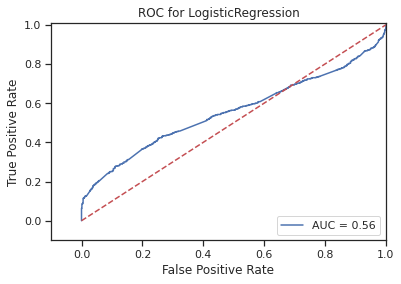

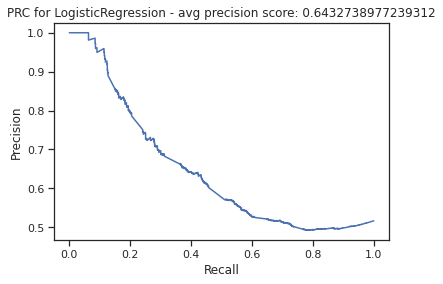

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed

============================= KNearest =============================
Mean cross validation score: 0.5697812499999999
Mean precision score: 0.5934615259641668
Mean Recall score: 0.5840193704600485
Mean ROC-AUC score: 0.5774102020258899
Mean F1 score: 0.5869251733454123
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.585207396301849
confusion matrix for the real test set:
 [[615 353]
 [477 556]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.56      0.64      0.60       968
           1       0.61      0.54      0.57      1033

    accuracy                           0.59      2001
   macro avg       0.59      0.59      0.58      2001
weighted avg       0.59      0.59      0.58      2001



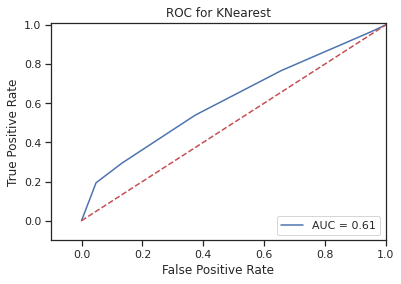

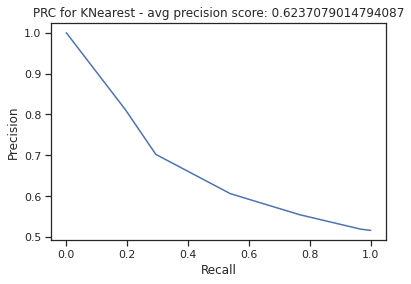

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

============================= Support Vector Classifier =============================
Mean cross validation score: 0.61309375
Mean precision score: 0.665418987911887
Mean Recall score: 0.5096852300242131
Mean ROC-AUC score: 0.61802090958575
Mean F1 score: 0.5771501776525858
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6091954022988506
confusion matrix for the real test set:
 [[698 270]
 [512 521]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.58      0.72      0.64       968
           1       0.66      0.50      0.57      1033

    accuracy                           0.61      2001
   macro avg       0.62      0.61      0.61      2001
weighted avg       0.62      0.61      0.60      2001

============================= DecisionTreeClassifier =============================
Mean cross validation score: 0.5796250000000001
Mean precision score: 0.5980145183614644
Mean Recall scor

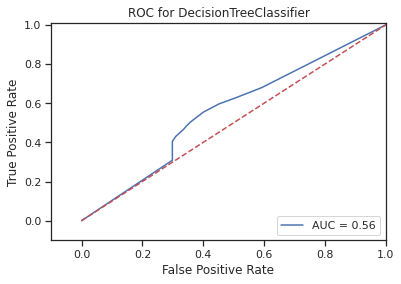

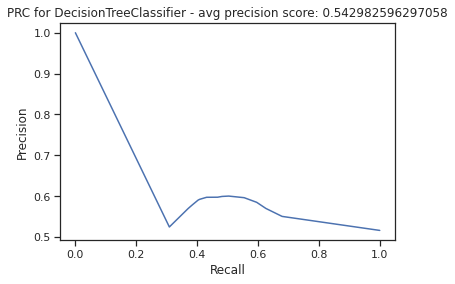

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

============================= Naive Bayes =============================
Mean cross validation score: 0.61309375
Mean precision score: 0.7172100446714953
Mean Recall score: 0.4150121065375303
Mean ROC-AUC score: 0.6200383530103672
Mean F1 score: 0.5256650086324701
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6051974012993503
confusion matrix for the real test set:
 [[788 180]
 [610 423]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.56      0.81      0.67       968
           1       0.70      0.41      0.52      1033

    accuracy                           0.61      2001
   macro avg       0.63      0.61      0.59      2001
weighted avg       0.63      0.61      0.59      2001



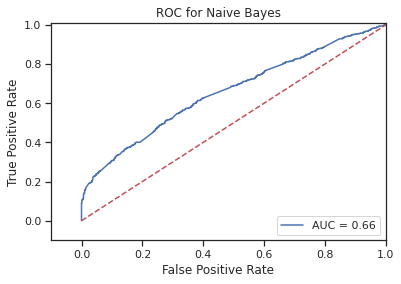

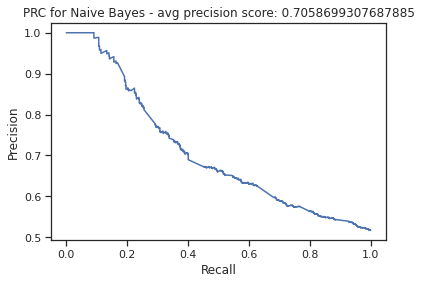

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed whe

============================= Random forests =============================
Mean cross validation score: 0.58175
Mean precision score: 0.6040953683018064
Mean Recall score: 0.576271186440678
Mean ROC-AUC score: 0.5863268076906232
Mean F1 score: 0.5895330539218159
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.5727136431784108
confusion matrix for the real test set:
 [[563 405]
 [450 583]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.56      0.58      0.57       968
           1       0.59      0.56      0.58      1033

    accuracy                           0.57      2001
   macro avg       0.57      0.57      0.57      2001
weighted avg       0.57      0.57      0.57      2001



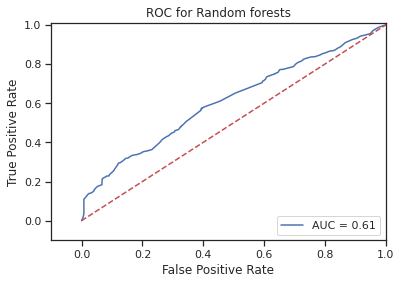

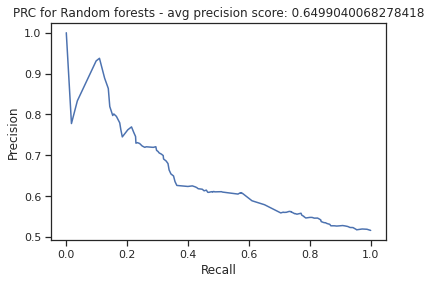

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

============================= XGBoost Classifier =============================
Mean cross validation score: 0.61425
Mean precision score: 0.6660269690267727
Mean Recall score: 0.511138014527845
Mean ROC-AUC score: 0.6183597049383411
Mean F1 score: 0.577471537932696
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6021989005497251
confusion matrix for the real test set:
 [[731 237]
 [559 474]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.57      0.76      0.65       968
           1       0.67      0.46      0.54      1033

    accuracy                           0.60      2001
   macro avg       0.62      0.61      0.60      2001
weighted avg       0.62      0.60      0.59      2001



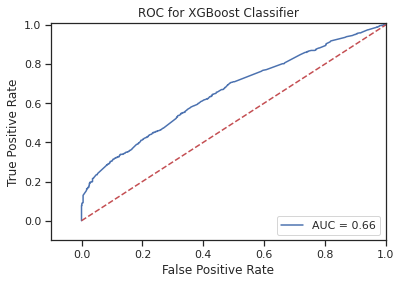

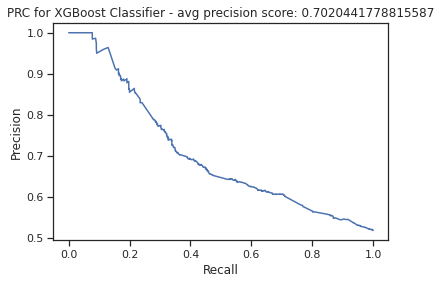

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

============================= GradientBoostingClassifier =============================
Mean cross validation score: 0.6125625
Mean precision score: 0.6669952205878428
Mean Recall score: 0.5130750605326877
Mean ROC-AUC score: 0.6194574269071708
Mean F1 score: 0.5790056807504367
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6071964017991005
confusion matrix for the real test set:
 [[740 228]
 [558 475]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.57      0.76      0.65       968
           1       0.68      0.46      0.55      1033

    accuracy                           0.61      2001
   macro avg       0.62      0.61      0.60      2001
weighted avg       0.62      0.61      0.60      2001



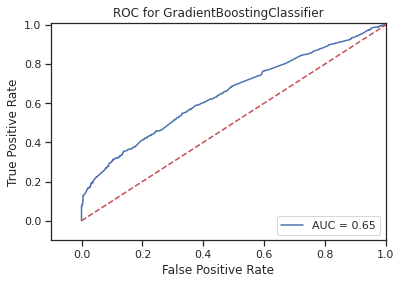

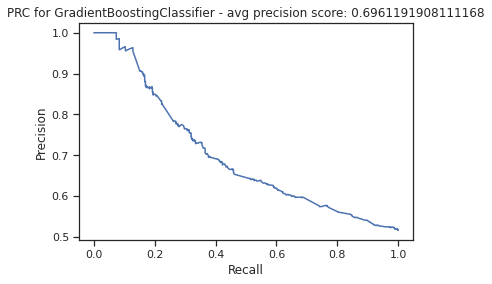

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d

============================= MLP Classifier =============================
Mean cross validation score: 0.61125
Mean precision score: 0.7028252372884862
Mean Recall score: 0.4486682808716707
Mean ROC-AUC score: 0.6207165693764037
Mean F1 score: 0.544377906916054
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6091954022988506
confusion matrix for the real test set:
 [[801 167]
 [615 418]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.57      0.83      0.67       968
           1       0.71      0.40      0.52      1033

    accuracy                           0.61      2001
   macro avg       0.64      0.62      0.59      2001
weighted avg       0.64      0.61      0.59      2001



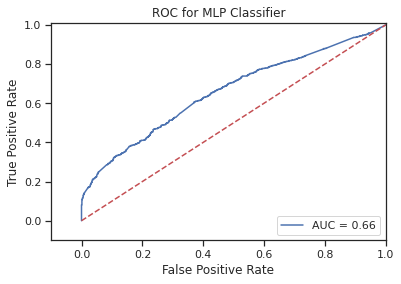

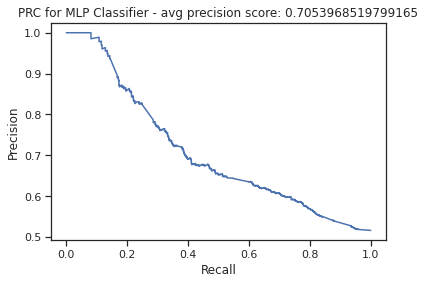

In [ ]:
run_all_models()

# Accuracies

#Factor 2 : Writting Style #
Team Member: Swati Narkhede

Writing style of any article can tell us alot about the authors and their motives. We can determine whether the content is True or False. 
We can identify fakeness of any article by examining the Sentiments generated by the sentence. Usually, a fake content contains strong sentiments. True article has neutral tone. 
To identify the fakeness of any article we can examine the gramatical mistakes, Writing quality and professionalism of the article.

1. Checking Writing quality by identifying the unprofessional words used in content. In informal conversation, we usually contract the words in content. Hence, here we will take count of contracted words.

In [ ]:
# To check if the writing style is professional or not we will use word contraction list and count the unprofessional words used in text

word_contractions_list = ['tis', 'aint', 'amnt', 'arent', 'cant', 'couldve', 'couldnt', 'couldntve',
                    'didnt', 'doesnt', 'dont', 'gonna', 'gotta', 'hadnt', 'hadntve', 'hasnt',
                    'havent', 'hed', 'hednt', 'hedve', 'hell', 'hes', 'hesnt', 'howd', 'howll',
                    'hows', 'id', 'idnt', 'idntve', 'idve', 'ill', 'im', 'ive', 'ivent', 'isnt',
                    'itd', 'itdnt', 'itdntve', 'itdve', 'itll', 'its', 'itsnt', 'mightnt',
                    'mightve', 'mustnt', 'mustntve', 'mustve', 'neednt', 'oclock', 'ol', 'oughtnt',
                    'shant', 'shed', 'shednt', 'shedntve', 'shedve', 'shell', 'shes', 'shouldve',
                    'shouldnt', 'shouldntve', 'somebodydve', 'somebodydntve', 'somebodys',
                    'someoned', 'someonednt', 'someonedntve', 'someonedve', 'someonell', 'someones',
                    'somethingd', 'somethingdnt', 'somethingdntve', 'somethingdve', 'somethingll',
                    'somethings', 'thatll', 'thats', 'thatd', 'thered', 'therednt', 'theredntve',
                    'theredve', 'therere', 'theres', 'theyd', 'theydnt', 'theydntve', 'theydve',
                    'theydvent', 'theyll', 'theyontve', 'theyre', 'theyve', 'theyvent', 'wasnt',
                    'wed', 'wedve', 'wednt', 'wedntve', 'well', 'wontve', 'were', 'weve', 'werent',
                    'whatd', 'whatll', 'whatre', 'whats', 'whatve', 'whens', 'whered', 'wheres',
                    'whereve', 'whod', 'whodve', 'wholl', 'whore', 'whos', 'whove', 'whyd', 'whyre',
                    'whys', 'wont', 'wontve', 'wouldve', 'wouldnt', 'wouldntve', 'yall', 'yalldve',
                    'yalldntve', 'yallll', 'yallont', 'yallllve', 'yallre', 'yallllvent', 'yaint',
                    'youd', 'youdve', 'youll', 'youre', 'yourent', 'youve', 'youvent','whose', 'whats', 'whatre', 'whenre', 'whens', 'couldnt', 'wheres', 'whered', 'whys', 'cant',
            'isnt','shouldnt','youre', 'youll', 'youd','heres','hows', 'howd', 'arent', 'doesnt']

In [ ]:
# Function to check the total number of unprofessional words used in text

def num_contraction(text):
    spl = text.split()
    num = len([word for word in spl if word in word_contractions_list])
    return num

The sentiments of a Fake news content are highly polarized. Either they are highly positive or highly negative. True news contents generate neutral sentiments. Hence, we will check Sentiment Polarity analysis and generate Compound Sentiment score in dataset.

In [ ]:
# Sentiment polarity Analysis

sia = SentimentIntensityAnalyzer()
def sentiment(text):
    score = sia.polarity_scores(text)
    return score['compound']


In [ ]:
merged_data.head()

,title,text,label,similarity_title_text,common_words_count
0,trump continu solicit illeg donat foreign lawmak,foreign nation includ lawmak polit type legal ...,1,0.335940,7
1,donald trump secret weapon letter love flatter...,one letter donald j trump rant crisi unsight h...,0,0.124028,10
2,preach gospel divers follow new york time,two report cover presidenti campaign new york ...,0,0.167501,4
3,ann coulter call fox news ted cruz take gop ci...,one seen believ liber longer accus fox news te...,1,0.155954,11
4,david friedman choic envoy israel hostil two s...,jerusalem presid american arm yeshiva settleme...,0,0.023734,9


In [ ]:
merged_data['num_contraction'] = merged_data['text'].apply(num_contraction)
merged_data['senti'] = merged_data['text'].apply(sentiment)

In [ ]:
# Creating processed doc and dictionary
processed_docs = merged_data['text'].map(lambda doc: doc.split(" "))

In [ ]:
#Function to get tokens of document
def get_tokens(text):
    token = []
    for tk in gensim.utils.simple_preprocess(text):
        if len(tk) > 3:
            token.append(tk)
    return token


In [ ]:
tokenized_docs = merged_data['text'].map(get_tokens)

In [ ]:
# Function to get dictionary
def get_dictionary(processed_docs):
    dict_gensim = gensim.corpora.Dictionary(processed_docs)
    dict_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dict_gensim

# Function to get Bag of Words
def get_bow_corpus(processed_docs, tokenized_docs):
    dict_gensim = get_dictionary(processed_docs)

    bow_corpus = [dict_gensim.doc2bow(doc) for doc in tokenized_docs]
    return bow_corpus


In [ ]:
dictionary = get_dictionary(processed_docs)
bow_corpus = get_bow_corpus(processed_docs, tokenized_docs)

In [ ]:
# Running LDA using Bag of Words on train dataset
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [ ]:
# Checking the topics and words
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.006*"like" + 0.006*"peopl" + 0.005*"trump" + 0.005*"time" + 0.005*"presid" + 0.004*"also" + 0.004*"year" + 0.004*"woman" + 0.003*"call" + 0.003*"work"
Topic: 1 
Words: 0.009*"state" + 0.007*"year" + 0.006*"trump" + 0.005*"govern" + 0.005*"report" + 0.004*"nation" + 0.004*"presid" + 0.004*"unit" + 0.004*"like" + 0.003*"also"
Topic: 2 
Words: 0.007*"year" + 0.006*"state" + 0.006*"govern" + 0.005*"attack" + 0.005*"peopl" + 0.004*"offici" + 0.004*"polic" + 0.004*"forc" + 0.004*"time" + 0.004*"group"
Topic: 3 
Words: 0.008*"clinton" + 0.008*"state" + 0.007*"american" + 0.007*"peopl" + 0.006*"trump" + 0.005*"year" + 0.005*"obama" + 0.005*"hillari" + 0.004*"also" + 0.004*"like"
Topic: 4 
Words: 0.024*"trump" + 0.007*"like" + 0.007*"peopl" + 0.005*"time" + 0.005*"presid" + 0.005*"donald" + 0.005*"know" + 0.004*"think" + 0.004*"year" + 0.004*"also"
Topic: 5 
Words: 0.009*"trump" + 0.006*"state" + 0.005*"time" + 0.005*"peopl" + 0.005*"year" + 0.004*"also" + 0.004*"govern" + 0.

In [ ]:
# Getting score
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9489530920982361	 
Topic: 0.008*"state" + 0.008*"presid" + 0.007*"clinton" + 0.007*"trump" + 0.006*"republican" + 0.005*"senat" + 0.004*"democrat" + 0.004*"campaign" + 0.004*"hous" + 0.004*"obama"

Score: 0.04877357557415962	 
Topic: 0.009*"trump" + 0.008*"republican" + 0.007*"state" + 0.006*"peopl" + 0.006*"hous" + 0.006*"presid" + 0.004*"also" + 0.004*"percent" + 0.004*"year" + 0.004*"bill"


In [ ]:
merged_data['LDA_Score'] = score

In [ ]:
merged_data.head()

,title,text,label,similarity_title_text,common_words_count,num_contraction,senti,LDA_Score
0,trump continu solicit illeg donat foreign lawmak,foreign nation includ lawmak polit type legal ...,1,0.335940,7,1,-0.0000,0.048774
1,donald trump secret weapon letter love flatter...,one letter donald j trump rant crisi unsight h...,0,0.124028,10,1,0.9946,0.048774
2,preach gospel divers follow new york time,two report cover presidenti campaign new york ...,0,0.167501,4,1,0.9565,0.048774
3,ann coulter call fox news ted cruz take gop ci...,one seen believ liber longer accus fox news te...,1,0.155954,11,0,-0.9601,0.048774
4,david friedman choic envoy israel hostil two s...,jerusalem presid american arm yeshiva settleme...,0,0.023734,9,2,0.9916,0.048774


*Training Model and Evaluation*

In [ ]:

merged_data = merged_data.drop(['title', 'text'], axis=1)
y = merged_data['label']  
X = merged_data.drop(['label'], axis=1)
X = X.fillna(0)
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Implementing Support Vector Machine Classifier

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svclassifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(y_test,y_pred))
print("Classification Report:\n")
print(classification_report(y_test,y_pred))
print('Accuracy score for SVM is :\n', accuracy_score(y_test, y_pred))


Confusion Matrix: 

[[794 643]
 [707 857]]
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.55      0.54      1437
           1       0.57      0.55      0.56      1564

    accuracy                           0.55      3001
   macro avg       0.55      0.55      0.55      3001
weighted avg       0.55      0.55      0.55      3001

Accuracy score for SVM is :
 0.5501499500166611


Using Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train,y_train)

pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(y_test,pred))
print("Classification Report:\n")
print(classification_report(y_test,pred))
print('Accuracy score for Naive Bayes:\n', accuracy_score(y_test, pred))

Confusion Matrix: 

[[1270  167]
 [1037  527]]
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.88      0.68      1437
           1       0.76      0.34      0.47      1564

    accuracy                           0.60      3001
   macro avg       0.65      0.61      0.57      3001
weighted avg       0.66      0.60      0.57      3001

Accuracy score for Naive Bayes:
 0.5988003998667111


Using KNearest Neighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
model.fit(X_train,y_train)

#Predict Output
predicted= model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(y_test,predicted))
print("Classification Report:\n")
print(classification_report(y_test,predicted))
print('Accuracy score for KNN Classifier:\n', accuracy_score(y_test, predicted))

Confusion Matrix: 

[[805 632]
 [620 944]]
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1437
           1       0.60      0.60      0.60      1564

    accuracy                           0.58      3001
   macro avg       0.58      0.58      0.58      3001
weighted avg       0.58      0.58      0.58      3001

Accuracy score for KNN Classifier:
 0.5828057314228591


From above results, we can see for Writing Style Factor, we are getting accuracy ranging from 51% to 60%.

# Factor 3: Misleading Intents#
Team member: Asha Aher

##3 Data Narative

**Mis-leading Intentions** – Mis-leading intension is described as the diverted or false sentence/text i.e. misleading someone when you point them in the wrong direction, metaphorically or literally.

Below are some examples:

Example 1– 

Example 2- If you give a stranger/passenger direction away from the place he's looking for, then you are misleading him.

**Data Narrative:**

Predicting whether the sentence/text is misleading or not. This could help to save from the false intentions.
Using this model, we can predict if the given content is honest or dishonest.

Approach Used –
Pre-processing steps required for the feature -"Misleading Intentions":

Adding labels to the dataset.

Removing Special Characters and Punctuations

Converting characters to Lower case

Removing Stop Words

Checking for null values and dropping the non-required columns.

One hot encoding for converting categorical values to numeric values.

Checking for null values and dropping the non-required columns.

Lemmatization for grouping together the different inflected forms of a word so they can be analyzed as a single item.

Stemming for producing morphological variants of a root/base word.



**Classification using three different algorithms:**


Naive Bayes
Decision Tree
Random Forest

**Classification with TF-IDF:**

Random Forest
Naive Bayes

Prediction Function using Pipeline and Calculating MI Score.


**Performance Evaluation:**

Performance of the classification algorithms are measured using –

Accuracy Score
Confusion Matrix
Precision
Recall
F1 Score



In [ ]:
import seaborn as sns; sns.set() 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument
import re
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk.corpus 
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as matplot_plt
import seaborn as seaborn_lib; seaborn_lib.set(style="ticks", color_codes=True)
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/Shared drives/SheCodes/Asha_Aher/AlternusVera/Liar_Liar'

/content/drive/Shared drives/SheCodes/Asha_Aher/AlternusVera/Liar_Liar


In [ ]:
column_name = ['id', 'label', 'statement', 'subjects', 'speaker','speaker_job title', 'state info', 'party affiliation', 'barely_true_counts','false_counts', 'half_true_counts',
           'mostly_true_counts', 'pants_on_fire_counts','context']
          
liar_liar_data_train = pd.read_csv("train.tsv", sep='\t', names = column_name, error_bad_lines=False)
liar_liar_data_test = pd.read_csv("test.tsv", sep='\t', names = column_name, error_bad_lines=False)
liar_liar_data_valid = pd.read_csv("valid.tsv", sep='\t', names = column_name, error_bad_lines=False)

In [ ]:
liar_liar_body_train = liar_liar_data_train

In [ ]:
liar_liar_body = pd.read_csv('/content/drive/Shared drives/SheCodes/Asha_Aher/AlternusVera/Fake_News.csv')
liar_liar_body.head()

,Unnamed: 0,jsonid,headline_text,body_text
0,0,2635,Says the Annies List political group supports ...,NaN
1,1,10540,When did the decline of coal start? It started...,Del. Scott Surovell has had it with Republican...
2,2,324,"Hillary Clinton agrees with John McCain ""by vo...","\nIn making his argument, Obama attacked Clint..."
3,3,1123,Health care reform legislation is likely to ma...,NaN
4,4,9028,The economic turnaround started at the end of ...,NaN


50722

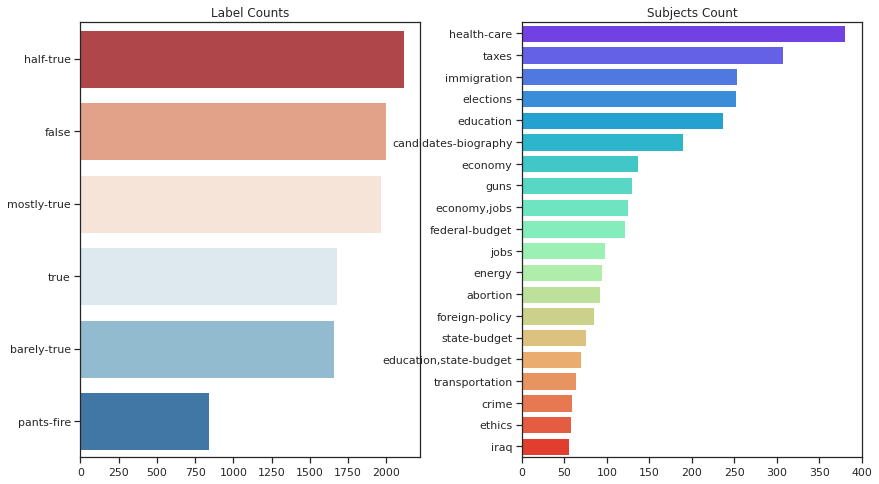

In [ ]:
import gc
f,ax = matplot_plt.subplots(1,2, figsize=(14,8))
ax1,ax2, = ax.flatten()
cnt = liar_liar_data_train['label'].value_counts()[:20].to_frame()

seaborn_lib.barplot(cnt['label'], cnt.index, palette = 'RdBu', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Label Counts')

cnt = liar_liar_data_train['subjects'].value_counts()[:20].to_frame()

seaborn_lib.barplot(cnt['subjects'], cnt.index, palette = 'rainbow', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Subjects Count')
matplot_plt.subplots_adjust(wspace=0.3)
gc.collect()

#Data Visualization


In [ ]:
liar_liar_train_sentences = liar_liar_data_train['statement']
liar_liar_train_sentences

0        Says the Annies List political group supports ...
1        When did the decline of coal start? It started...
2        Hillary Clinton agrees with John McCain "by vo...
3        Health care reform legislation is likely to ma...
4        The economic turnaround started at the end of ...
                               ...                        
10235    There are a larger number of shark attacks in ...
10236    Democrats have now become the party of the [At...
10237    Says an alternative to Social Security that op...
10238    On lifting the U.S. Cuban embargo and allowing...
10239    The Department of Veterans Affairs has a manua...
Name: statement, Length: 10240, dtype: object

In [ ]:
liar_liar_test_sentences = liar_liar_data_test['statement']
liar_liar_test_sentences

0       Building a wall on the U.S.-Mexico border will...
1       Wisconsin is on pace to double the number of l...
2       Says John McCain has done nothing to help the ...
3       Suzanne Bonamici supports a plan that will cut...
4       When asked by a reporter whether hes at the ce...
                              ...                        
1262    Says his budget provides the highest state fun...
1263                      Ive been here almost every day.
1264    In the early 1980s, Sen. Edward Kennedy secret...
1265    Says an EPA permit languished under Strickland...
1266    Says the governor is going around the state ta...
Name: statement, Length: 1267, dtype: object

In [ ]:
liar_liar_valid_sentences = liar_liar_data_valid['statement']
liar_liar_valid_sentences

0       We have less Americans working now than in the...
1       When Obama was sworn into office, he DID NOT u...
2       Says Having organizations parading as being so...
3          Says nearly half of Oregons children are poor.
4       On attacks by Republicans that various program...
                              ...                        
1279    For the first time in more than a decade, impo...
1280    Says Donald Trump has bankrupted his companies...
1281    John McCain and George Bush have "absolutely n...
1282    A new poll shows 62 percent support the presid...
1283    No one claims the report vindicating New Jerse...
Name: statement, Length: 1284, dtype: object

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [ ]:
def word_cloud_visualization_plot(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

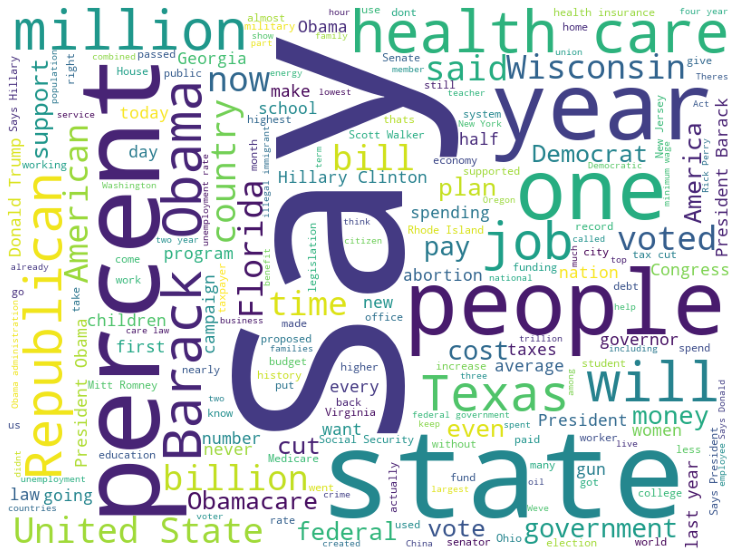

In [ ]:
word_cloud_visualization_plot(' '.join(liar_liar_train_sentences))

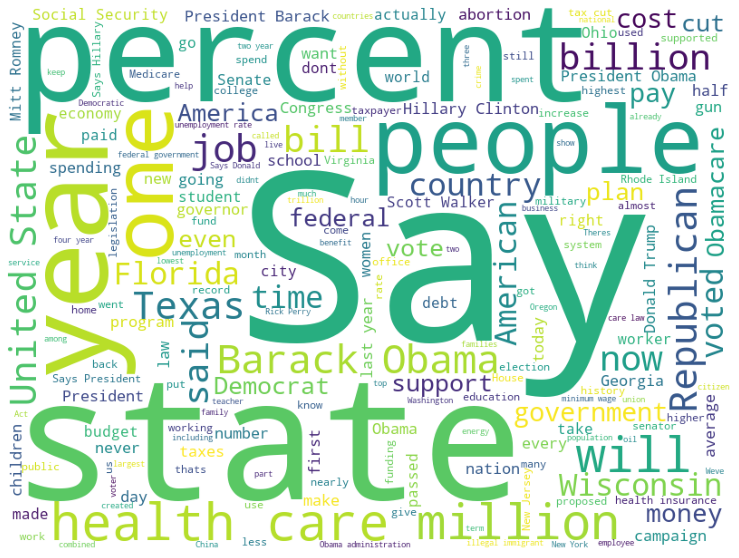

In [ ]:
word_cloud_visualization_plot(' '.join(liar_liar_train_sentences))

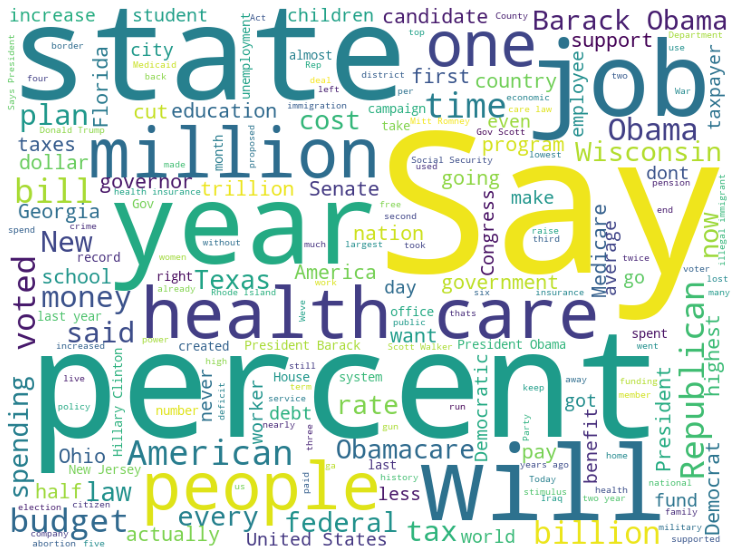

In [ ]:
word_cloud_visualization_plot(' '.join(liar_liar_valid_sentences))

#Data Preparation

In [ ]:
def categorization(label):
    if label == "false":
        return 'False'
    elif label == "pants-fire":
        return 'False'
    elif label == "barely-true":
        return 'True'
    elif label == "half-true":
        return 'True'
    elif label == "mostly-true":
        return 'True'
    elif label == "true":
        return 'True'

In [ ]:
for index,row in liar_liar_body_train.iterrows():
    liar_liar_body_train.loc[index,'Label'] = categorization(liar_liar_body_train.loc[index,'label'])

In [ ]:
liar_liar_body_train['body_text'] = liar_liar_body['body_text']
liar_liar_body_train.tail(10)
print(liar_liar_body_train.shape)

(10240, 16)


#Importing Required libraries

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [ ]:
liar_liar_train_clean_sentences = pd.Series(liar_liar_train_sentences).str.replace("[^a-zA-Z]", " ")

In [ ]:
liar_liar_train_clean_sentences = [s.lower() for s in liar_liar_train_clean_sentences]

In [ ]:
liar_liar_train_clean_sentences = [remove_stopwords(r.split()) for r in liar_liar_train_clean_sentences]

In [ ]:
liar_liar_test_clean_sentences = pd.Series(liar_liar_test_sentences).str.replace("[^a-zA-Z]", " ")

In [ ]:
liar_liar_test_clean_sentences = [s.lower() for s in liar_liar_test_clean_sentences]

In [ ]:
liar_liar_test_clean_sentences = [remove_stopwords(r.split()) for r in liar_liar_test_clean_sentences]

In [ ]:
# removing punctuations, numbers and special characters
liar_liar_valid_clean_sentences = pd.Series(liar_liar_valid_sentences).str.replace("[^a-zA-Z]", " ")

# making alphabets lowercase
liar_liar_valid_clean_sentences = [s.lower() for s in liar_liar_valid_clean_sentences]

In [ ]:
# removing stopwords from the sentences
liar_liar_valid_clean_sentences = [remove_stopwords(r.split()) for r in liar_liar_valid_clean_sentences]

In [ ]:
#dropping columns
drop_columns = ['id','subjects', 'speaker', 'context','speaker_job title', 'state info','party affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts',
                   'mostly_true_counts', 'pants_on_fire_counts']
df_train = liar_liar_data_train.drop(columns=drop_columns)
df_test = liar_liar_data_test.drop(columns=drop_columns)
df_train.tail()

,label,statement,Label,body_text
10235,mostly-true,There are a larger number of shark attacks in ...,True,NaN
10236,mostly-true,Democrats have now become the party of the [At...,True,NaN
10237,half-true,Says an alternative to Social Security that op...,True,NaN
10238,false,On lifting the U.S. Cuban embargo and allowing...,False,NaN
10239,pants-fire,The Department of Veterans Affairs has a manua...,False,NaN


One Hot Encoding to convert categorical column to numerical column:

In [ ]:
def convertCatToBinary(v):
    value = v['label']
    if (value == 'true'):
        return '0'
    if (value == 'mostly-true'):
        return '1'
    if (value == 'half-true'):
        return '2'
    if (value == 'barely-true'):
        return '3'
    if (value == 'false'):
        return '4'
    if (value == 'pants-fire'):
        return '5'
df_train['label'] = df_train.apply(convertCatToBinary, axis=1)
df_test['label'] = df_test.apply(convertCatToBinary, axis=1)
df_train.tail()

,label,statement,Label,body_text
10235,1,There are a larger number of shark attacks in ...,True,NaN
10236,1,Democrats have now become the party of the [At...,True,NaN
10237,2,Says an alternative to Social Security that op...,True,NaN
10238,4,On lifting the U.S. Cuban embargo and allowing...,False,NaN
10239,5,The Department of Veterans Affairs has a manua...,False,NaN


In [ ]:
print("Number of Rows and Columns::", df_train.shape)
print(df_train.loc[0])

Number of Rows and Columns:: (10240, 4)
label                                                        4
statement    Says the Annies List political group supports ...
Label                                                    False
body_text                                                  NaN
Name: 0, dtype: object


In [ ]:
X_train = df_train["statement"]
Y_train = df_train["label"]

In [ ]:
label_count = pd.crosstab(df_train['statement'],df_train['label'],margins=True)
label_count.head()

label,0,1,2,3,4,5,All
statement,,,,,,,
"#Business formation is still on the rise in Ohio! So far in 2011 weve assisted w/ 44,443 new business filings.",0,1,0,0,0,0,1
#GradInsurance debacle is a DIRECT result of #ObamaCare. #MIZZOU has to break the law to do the right thing.,0,0,1,0,0,0,1
"$100,000 in stimulus funds (were) used for a Martini Bar and Brazilian Steakhouse.",0,1,0,0,0,0,1
"$120,000 will be spent by taxpayers on Charlie Crists political photo-op special session.",0,1,0,0,0,0,1
$16 trillion (the national debt) in $1 bills would cover the entire state of Ohio nearly 1.5 times.,1,0,0,0,0,0,1


In [ ]:
print(WordNetLemmatizer().lemmatize('went', pos='v'))

go


In [ ]:
stemmerization = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmerization.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


Function to perform lemmatize and stem preprocessing steps on the required data set

In [ ]:
def lemmatize_stemming_text(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocessing(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming_text(token))
    return result

Using Word2Vec

In [ ]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence

def labelled_sentences(articles, label_type):
    labelledSentences = []
    for i,_d in enumerate(articles):
        labelledSentences.append(LabeledSentence(_d, label_type[i]))
    return labelledSentences

In [ ]:
df_train_labelled = labelled_sentences(df_train['statement'],df_train['label'])
df_train_labelled[1]

LabeledSentence(words='When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.', tags='2')

In [ ]:
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(df_train['statement'])]

In [ ]:
tagged_data_words=[x.words for x in tagged_data]
tagged_data_words_1D=[]
for row in range(len(tagged_data_words)):
    for col in range(len(tagged_data_words[row])):
        tagged_data_words_1D.append(tagged_data_words[row][col])

In [ ]:
n_dim=300
w2v = Word2Vec(size=n_dim, min_count=0)
w2v.build_vocab(tagged_data_words)
w2v.train(tagged_data_words,total_examples=w2v.corpus_count,epochs=w2v.epochs)

(1217814, 5474240)

In [ ]:
df_train_statements=df_train[['statement','label']]
df_train_statements_vectorized=df_train_statements['statement'].map(lambda x: [w2v[w] for w in x])

In [ ]:
df_train_statements['statement']=df_train_statements_vectorized

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train_statements['label']=le.fit_transform(df_train_statements['label'])

In [ ]:
df_train_statements.head()

,statement,label
0,"[[0.87323445, 0.08998459, -0.08207345, -0.1132...",4
1,"[[0.040507413, -0.1831263, -0.32194087, -0.513...",2
2,"[[-0.138374, 0.0865988, 0.10823632, -0.1883641...",1
3,"[[-0.138374, 0.0865988, 0.10823632, -0.1883641...",4
4,"[[-0.30960372, 0.3409276, 0.57632005, 0.464358...",2


In [ ]:
def document_vector(doc):
    return np.mean(doc, axis=0)

In [ ]:
for row_idx in range(len(df_train_statements['statement'])):
    for col_idx in range(len(df_train_statements['statement'][row_idx])):
        df_train_statements['statement'][row_idx][col_idx]=document_vector(df_train_statements['statement'][row_idx][col_idx])

In [ ]:
df_train_statements.drop(index=4497,inplace=True)
df_train_statements.reset_index(drop=True)

,statement,label
0,"[0.0009743206, -0.0022942112, 0.0065051685, 0....",4
1,"[-0.006978592, 0.01859543, 0.014645264, 0.0098...",2
2,"[-0.019625997, -0.010072657, -0.0009309582, -0...",1
3,"[-0.019625997, 0.014645264, -0.0022942112, -0....",4
4,"[0.026190015, 0.01859543, 0.014645264, 0.00480...",2
...,...,...
10234,"[0.026190015, 0.01859543, 0.014645264, 0.00098...",1
10235,"[-0.0046619126, 0.014645264, 0.006589947, 0.00...",1
10236,"[0.0009743206, -0.0022942112, 0.0065051685, 0....",2
10237,"[0.0035778093, 0.009809133, 0.004803304, -0.00...",4


Converting Word Vec to Features:

In [ ]:

texts=[]
for x in df_train_statements['statement'].values:
    texts.append(x)   
X=pd.DataFrame(texts)
X=X.fillna(0)
y=df_train_statements[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Using Doc2Vec

In [ ]:
df_doc2vec = df_train
df_doc2vec = df_doc2vec[['statement','label']]
df_doc2vec = df_doc2vec[pd.notnull(df_doc2vec['statement'])]
df_doc2vec.head(10)

,statement,label
0,Says the Annies List political group supports ...,4
1,When did the decline of coal start? It started...,2
2,"Hillary Clinton agrees with John McCain ""by vo...",1
3,Health care reform legislation is likely to ma...,4
4,The economic turnaround started at the end of ...,2
5,The Chicago Bears have had more starting quart...,0
6,Jim Dunnam has not lived in the district he re...,3
7,I'm the only person on this stage who has work...,2
8,"However, it took $19.5 million in Oregon Lotte...",2
9,Says GOP primary opponents Glenn Grothman and ...,1


In [ ]:
df_doc2vec['statement'].apply(lambda x: len(x.split(' '))).sum()

184014

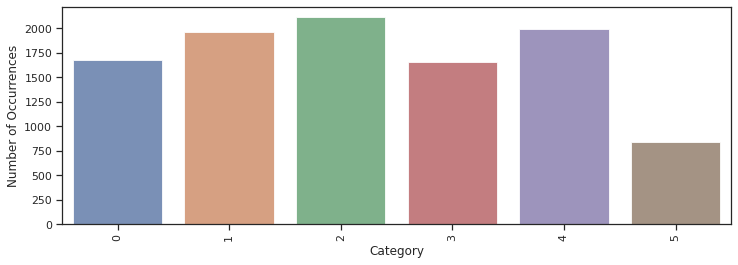

In [ ]:
cnt_pro = df_doc2vec['label'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

Using TF-IDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
countV = CountVectorizer(stop_words='english', min_df=2, max_df=20, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
 
train_count = countV.fit_transform(df_train['statement'].values)
test_count = countV.fit_transform(df_test['statement'].values)
print('COUNT VECTORIZER')


countVPlurals= countV.get_feature_names()
stemmer = PorterStemmer()
countVSingles= [stemmer.stem(plural) for plural in countVPlurals]


countVTokens = list(set(countVSingles))
print('countVTokens')
print(countVTokens)
print('------------------------------------------')
                         

tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
train_tfidf = tfidfV.fit_transform(df_train['statement'].values)
test_tfidf = tfidfV.fit_transform(df_test['statement'].values)

print('TF-IDF VECTORIZER')


tfidfVPlurals= tfidfV.get_feature_names()
tfidfVSingles= [stemmer.stem(plural) for plural in tfidfVPlurals]

tfidfVTokens = list(set(tfidfVSingles))
print('TFIDFV Tokens')
print(tfidfVTokens)

COUNT VECTORIZER
countVTokens
['estat', 'accept', 'there', 'volunt', 'condit', 'allow', 'question', 'score', 'size', 'amount', 'trust', 'near', 'teacher', '1960', 'exempt', 'identif', 'registr', 'support', 'databas', 'design', 'major', 'jersey', 'provid', 'biden', 'mean', 'introduc', 'commit', 'he', 'option', 'intern', 'congresswoman', 'stamp', 'think', 'nazi', 'russia', 'market', 'scienc', 'mack', 'jim', 'virginia', 'fast', 'oil', 'posit', 'prison', 'mccollum', 'guard', 'arm', 'cut', 'feet', 'mac', 'fraud', 'worth', 'taken', 'north', 'catherin', 'day', 'rape', 'receiv', '2nd', 'fastest', 'cortez', 'close', 'cruz', 'waiver', 'great', 'island', 'romney', 'lower', 'theft', 'doctor', 'veteran', 'corpor', 'liter', 'medic', 'investig', 'announc', 'member', 'real', 'exist', 'senior', 'stage', 'amnesti', 'bear', 'bid', 'discrimin', 'qualifi', 'homeland', 'foundat', 'fire', 'loan', 'trade', 'sexual', 'chairman', 'christi', 'independ', 'far', 'masto', 'told', 'disabl', 'past', 'waterboard', 'co

In [ ]:
count_df = pd.DataFrame(df_train['statement'], columns=countV.get_feature_names())
tfidf_df = pd.DataFrame(df_test['statement'], columns=tfidfV.get_feature_names())
difference = set(count_df.columns) - set(tfidf_df.columns)
difference
print(count_df.equals(tfidf_df))
count_df.tail()
tfidf_df.head()

False


,abortion,abortions,act,actually,added,administration,administrations,affordable,afghanistan,african,age,ago,aids,allowed,allowing,amendment,america,approval,asked,assault,assembly,atlanta,attorney,austin,average,background,ballot,ban,based,benefits,best,big,biggest,black,board,border,born,breaks,brought,brown,...,tuition,twice,unemployment,university,use,used,violence,virginia,vote,voter,votes,voting,wage,walker,wall,want,wants,war,washington,water,way,weapons,weeks,went,weve,white,wisconsin,wisconsins,women,won,work,workers,workforce,working,world,worse,worst,worth,york,young


#Classification Algorithms#

Applying Desicion Tree Classification:

In [ ]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)
dec_pred = clf_gini.predict(X_test)
accuracy_score =  clf_gini.score(X_test, y_test)
print ("Accuracy Score:", accuracy_score)

print(metrics.classification_report(y_test,dec_pred))

Accuracy Score: 0.22591145833333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       493
           1       0.22      0.46      0.29       586
           2       0.24      0.29      0.26       638
           3       0.25      0.00      0.00       531
           4       0.23      0.41      0.29       596
           5       0.00      0.00      0.00       228

    accuracy                           0.23      3072
   macro avg       0.16      0.19      0.14      3072
weighted avg       0.18      0.23      0.17      3072



Applying Random Forest Classification Algorithm:

In [ ]:
num_trees=200

rf=RandomForestClassifier(n_estimators=num_trees)
rf_pred= rf.fit(X_train, y_train)
rf_pred=rf.predict(X_test)
accuracy_score = rf.score(X_test, y_test)
print ("Accuracy Score:", accuracy_score)
print(metrics.classification_report(y_test,rf_pred))

Accuracy Score: 0.2099609375
              precision    recall  f1-score   support

           0       0.16      0.06      0.09       493
           1       0.19      0.27      0.22       586
           2       0.24      0.44      0.31       638
           3       0.11      0.02      0.03       531
           4       0.22      0.27      0.24       596
           5       0.00      0.00      0.00       228

    accuracy                           0.21      3072
   macro avg       0.15      0.18      0.15      3072
weighted avg       0.17      0.21      0.17      3072



Analysis: As we can see from above algorithms, accuracy for classification models based on word vector is in between 30 - 45 %, which will not help much in achieveing our accurate target.

Classification Algorithms - TF-IDF:

**Naive Bayes Classifier for TF-IDF:**

In [ ]:
nb_pipeline = Pipeline([
        ('NBCV',tfidfV),
        ('nb_clf',MultinomialNB())])

nb_pipeline.fit(df_doc2vec['statement'],df_doc2vec['label'])
predicted_nb_tf = nb_pipeline.predict(df_doc2vec['statement'])
np.mean(predicted_nb_tf == df_doc2vec['label'])

0.48466796875

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_doc2vec['label'], predicted_nb_tf)
print('Confusion Matrix for the Naive Bayes algorithm is: %s \n' % confusion_matrix)

from sklearn.metrics import classification_report
print('Classification Report Naive Bayes Algorithm is: \n')
print(classification_report(df_doc2vec['label'], predicted_nb_tf))

Confusion Matrix for the Naive Bayes algorithm is: [[ 666  228  468   88  224    2]
 [ 120 1011  500  112  219    0]
 [ 106  235 1464   88  218    3]
 [ 102  213  437  662  238    2]
 [  99  199  505  120 1071    1]
 [  72  116  255   88  219   89]] 

Classification Report Naive Bayes Algorithm is: 

              precision    recall  f1-score   support

           0       0.57      0.40      0.47      1676
           1       0.50      0.52      0.51      1962
           2       0.40      0.69      0.51      2114
           3       0.57      0.40      0.47      1654
           4       0.49      0.54      0.51      1995
           5       0.92      0.11      0.19       839

    accuracy                           0.48     10240
   macro avg       0.58      0.44      0.44     10240
weighted avg       0.54      0.48      0.47     10240



Logistic Regression Classifier for TF-IDF:

In [ ]:
logR_pipeline = Pipeline([
        ('LogRCV', tfidfV),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline.fit(df_doc2vec['statement'],df_doc2vec['label'])
predicted_lr_tf = logR_pipeline.predict(df_doc2vec['statement'])
np.mean(predicted_lr_tf == df_doc2vec['label'])

0.5130859375

Random Forest Classifier for TF-IDF:

In [ ]:
rf_pipeline = Pipeline([
        ('rftf',tfidfV),
        ('random_clf',RandomForestClassifier(n_estimators=num_trees))])

rf_pipeline.fit(df_doc2vec['statement'],df_doc2vec['label'])
predicted_rf_tf = rf_pipeline.predict(df_doc2vec['statement'])
np.mean(predicted_rf_tf == df_doc2vec['label'])

0.86142578125

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_doc2vec['label'], predicted_rf_tf)
print('Confusion Matrix for the Random Forest Algorithm is: %s \n' % confusion_matrix)

from sklearn.metrics import classification_report
print('Classification Report for Random Forest Algorithm is: \n')
print(classification_report(df_doc2vec['label'], predicted_rf_tf))

Confusion Matrix for the Random Forest Algorithm is: [[1420   24   29   19  178    6]
 [  31 1651   36   22  217    5]
 [  33   36 1790   13  232   10]
 [  28   33   38 1389  157    9]
 [  24   27   37   24 1864   19]
 [  10    8   15    6   93  707]] 

Classification Report for Random Forest Algorithm is: 

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1676
           1       0.93      0.84      0.88      1962
           2       0.92      0.85      0.88      2114
           3       0.94      0.84      0.89      1654
           4       0.68      0.93      0.79      1995
           5       0.94      0.84      0.89       839

    accuracy                           0.86     10240
   macro avg       0.89      0.86      0.87     10240
weighted avg       0.88      0.86      0.86     10240



In [ ]:
#we got maximum Accuracy in Random Forest

def getMisleadingIntention(content):
    rf_pipeline = Pipeline([
            ('rfcv',countV),
            ('random_clf',RandomForestClassifier(n_estimators=num_trees))])

    rf_pipeline.fit(df_doc2vec['statement'],df_doc2vec['label'])
    predicted_rf_cv = rf_pipeline.predict([content])
    return predicted_rf_cv[0]

In [ ]:
#we got maximum Accuracy in Random Forest

def getMisleadingIntention(content):
    rf_pipeline = Pipeline([
            ('rfcv',countV),
            ('random_clf',RandomForestClassifier(n_estimators=num_trees))])

    rf_pipeline.fit(df_doc2vec['statement'],df_doc2vec['label'])
    predicted_rf_cv = rf_pipeline.predict([content])
    return predicted_rf_cv[0]

#*6 Metrics and Evaluation*#

**Calculated Accuracy, Precision, Recall, F1 and Confusion Matrix.**

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words='english', min_df=2, max_df=20, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')),
    ('tfidf', TfidfTransformer()), 
    ('classifier', MultinomialNB()),  
])
pipeline.fit(df_doc2vec['statement'],df_doc2vec['label'])

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=20,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?ui)\\b\\w*[a-z]+\\w*\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
import itertools
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Evaluation of Naive Bayes Classifier TF-IDF:**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_doc2vec['label'], predicted_nb_tf)
print('Confusion Matrix for the Naive Bayes algorithm is: %s \n' % confusion_matrix)

from sklearn.metrics import classification_report
print('Classification Report Naive Bayes Classifier TF-IDF is:: \n')
print(classification_report(df_doc2vec['label'], predicted_nb_tf))

Confusion Matrix for the Naive Bayes algorithm is: [[ 666  228  468   88  224    2]
 [ 120 1011  500  112  219    0]
 [ 106  235 1464   88  218    3]
 [ 102  213  437  662  238    2]
 [  99  199  505  120 1071    1]
 [  72  116  255   88  219   89]] 

Classification Report Naive Bayes Classifier TF-IDF is:: 

              precision    recall  f1-score   support

           0       0.57      0.40      0.47      1676
           1       0.50      0.52      0.51      1962
           2       0.40      0.69      0.51      2114
           3       0.57      0.40      0.47      1654
           4       0.49      0.54      0.51      1995
           5       0.92      0.11      0.19       839

    accuracy                           0.48     10240
   macro avg       0.58      0.44      0.44     10240
weighted avg       0.54      0.48      0.47     10240



Confusion matrix, without normalization
[[ 666  228  468   88  224    2]
 [ 120 1011  500  112  219    0]
 [ 106  235 1464   88  218    3]
 [ 102  213  437  662  238    2]
 [  99  199  505  120 1071    1]
 [  72  116  255   88  219   89]]
Normalized confusion matrix
[[3.97374702e-01 1.36038186e-01 2.79236277e-01 5.25059666e-02
  1.33651551e-01 1.19331742e-03]
 [6.11620795e-02 5.15290520e-01 2.54841998e-01 5.70846075e-02
  1.11620795e-01 0.00000000e+00]
 [5.01419111e-02 1.11163671e-01 6.92526017e-01 4.16272469e-02
  1.03122044e-01 1.41911069e-03]
 [6.16686820e-02 1.28778718e-01 2.64207981e-01 4.00241838e-01
  1.43893591e-01 1.20918984e-03]
 [4.96240602e-02 9.97493734e-02 2.53132832e-01 6.01503759e-02
  5.36842105e-01 5.01253133e-04]
 [8.58164482e-02 1.38259833e-01 3.03933254e-01 1.04886770e-01
  2.61025030e-01 1.06078665e-01]]


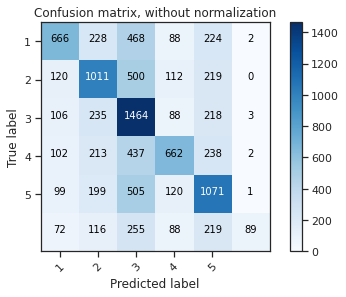

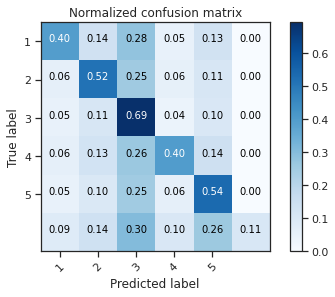

In [ ]:
class_names = ['1','2','3','4','5']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

**Evaluation of Logistic Regression Classifier TF-IDF:**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_doc2vec['label'], predicted_lr_tf)
print('Confusion Matrix for Logistic Regression Classifier is: %s \n' % confusion_matrix)

from sklearn.metrics import classification_report
print('Classification Report for Logistic Regression Classifier TF-IDF is: \n')
print(classification_report(df_doc2vec['label'], predicted_lr_tf))

Confusion Matrix for Logistic Regression Classifier is: [[ 750  211  250   97  364    4]
 [ 141 1035  271  112  399    4]
 [ 123  219 1261  106  397    8]
 [ 112  190  254  751  341    6]
 [ 115  178  264  130 1296   12]
 [  77  107  149   84  261  161]] 

Classification Report for Logistic Regression Classifier TF-IDF is: 

              precision    recall  f1-score   support

           0       0.57      0.45      0.50      1676
           1       0.53      0.53      0.53      1962
           2       0.51      0.60      0.55      2114
           3       0.59      0.45      0.51      1654
           4       0.42      0.65      0.51      1995
           5       0.83      0.19      0.31       839

    accuracy                           0.51     10240
   macro avg       0.58      0.48      0.49     10240
weighted avg       0.55      0.51      0.51     10240



Confusion matrix, without normalization
[[ 750  211  250   97  364    4]
 [ 141 1035  271  112  399    4]
 [ 123  219 1261  106  397    8]
 [ 112  190  254  751  341    6]
 [ 115  178  264  130 1296   12]
 [  77  107  149   84  261  161]]
Normalized confusion matrix
[[0.44749403 0.12589499 0.14916468 0.05787589 0.21718377 0.00238663]
 [0.07186544 0.52752294 0.13812436 0.05708461 0.20336391 0.00203874]
 [0.05818354 0.10359508 0.59649953 0.05014191 0.18779565 0.0037843 ]
 [0.06771463 0.11487304 0.15356711 0.45405079 0.20616687 0.00362757]
 [0.05764411 0.08922306 0.13233083 0.06516291 0.64962406 0.00601504]
 [0.09177592 0.12753278 0.17759237 0.10011919 0.31108462 0.19189511]]


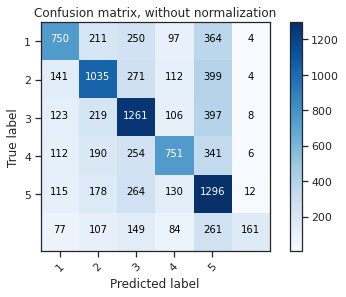

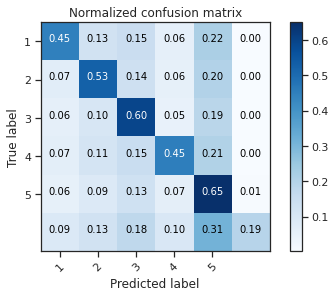

In [ ]:
class_names = ['1','2','3','4','5']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

**Evaluation of Random Forest Classifier TF-IDF:**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_doc2vec['label'], predicted_rf_tf)
print('Confusion Matrix for the Random Forest Algorithm is: %s \n' % confusion_matrix)

from sklearn.metrics import classification_report
print('Classification Report for Random Forest Classifier TF-IDF is: \n')
print(classification_report(df_doc2vec['label'], predicted_rf_tf))

Confusion Matrix for the Random Forest Algorithm is: [[1420   24   29   19  178    6]
 [  31 1651   36   22  217    5]
 [  33   36 1790   13  232   10]
 [  28   33   38 1389  157    9]
 [  24   27   37   24 1864   19]
 [  10    8   15    6   93  707]] 

Classification Report for Random Forest Classifier TF-IDF is: 

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1676
           1       0.93      0.84      0.88      1962
           2       0.92      0.85      0.88      2114
           3       0.94      0.84      0.89      1654
           4       0.68      0.93      0.79      1995
           5       0.94      0.84      0.89       839

    accuracy                           0.86     10240
   macro avg       0.89      0.86      0.87     10240
weighted avg       0.88      0.86      0.86     10240



Confusion matrix, without normalization
[[1420   24   29   19  178    6]
 [  31 1651   36   22  217    5]
 [  33   36 1790   13  232   10]
 [  28   33   38 1389  157    9]
 [  24   27   37   24 1864   19]
 [  10    8   15    6   93  707]]
Normalized confusion matrix
[[0.84725537 0.01431981 0.0173031  0.01133652 0.10620525 0.00357995]
 [0.0158002  0.84148828 0.01834862 0.01121305 0.11060143 0.00254842]
 [0.01561022 0.01702933 0.84673605 0.00614948 0.10974456 0.00473037]
 [0.01692866 0.01995163 0.02297461 0.83978235 0.0949214  0.00544135]
 [0.01203008 0.01353383 0.01854637 0.01203008 0.93433584 0.00952381]
 [0.01191895 0.00953516 0.01787843 0.00715137 0.11084625 0.84266985]]


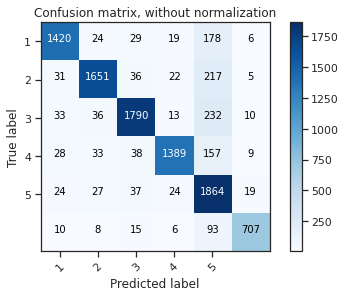

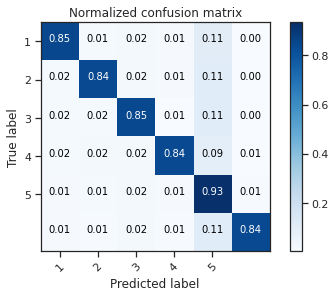

In [ ]:
class_names = ['1','2','3','4','5']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

**Feature Analysis on : Content Statitics:**

By Team Member: Sri Sruthi Chilukuri

When it comes to exploting data using statistical methods, we can use exploratory graphics

These are the priliminary steps we apply to the data in hand to: 1.feel the data- see their distributions and shape 2.check assumptions-and dependencies; correlations 3.check if the data assumptions match the methods/models we got to use 4.check for anomalies-outliers and unusual distributions and errors 5.get suggestions-help us persue a different angle or different method of analysis

why exploratory graphics? -information dense -best way to check for shape, gaps or outliers

with one variable: we use univariate distributions like bar chart.

boxplots for qualitataive variables; detect outliers histograms

scatterplot

multivariate distributions:

overall, content statistics help us with: have what u need? are there clumps or gaps? exceptional cases? errors in data?

exploratory statistics:

dealing with numerics in the data
what we do? -we explore the data -get emperical estimates

manipulate data(like transforming variables)
check sensitivity of results
robust statistics: -resampling technique - like cross validation -transforming - like smoothing functions fix skewed dataset

descriptive statistics: -tell data stroy use little data to stand in for a lot of data

use center of data - mean,mode,median
consider the spread of the data - ramge, percentiles, interquartile range, variance and std deviation
-

In [ ]:
df_fake=df_kaggle
df_fake

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,0
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,1
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,0
5198,25998,300 US Marines To Be Deployed To Russian Borde...,NaN,« Previous - Next » 300 US Marines To Be Deplo...,1


In [ ]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      26000 non-null  int64 
 1   title   25320 non-null  object
 2   author  23540 non-null  object
 3   text    25954 non-null  object
 4   label   26000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


In [ ]:
ff = df_fake[['title','text','label']]
ff

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...
5195,The Bangladeshi Traffic Jam That Never Ends - ...,Of all the dysfunctions that plague the world’...,0
5196,John Kasich Signs One Abortion Bill in Ohio bu...,WASHINGTON — Gov. John Kasich of Ohio on Tu...,1
5197,"California Today: What, Exactly, Is in Your Su...",Good morning. (Want to get California Today by...,0
5198,300 US Marines To Be Deployed To Russian Borde...,« Previous - Next » 300 US Marines To Be Deplo...,1


Checking for NaN and missing samples in the data and performing data cleaning

In [ ]:
ff['title'].isna().sum()

680

In [ ]:
fake_final=fake_final.dropna()

In [ ]:
fake_final.reset_index(drop=True)
ff

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...
5195,The Bangladeshi Traffic Jam That Never Ends - ...,Of all the dysfunctions that plague the world’...,0
5196,John Kasich Signs One Abortion Bill in Ohio bu...,WASHINGTON — Gov. John Kasich of Ohio on Tu...,1
5197,"California Today: What, Exactly, Is in Your Su...",Good morning. (Want to get California Today by...,0
5198,300 US Marines To Be Deployed To Russian Borde...,« Previous - Next » 300 US Marines To Be Deplo...,1


In [ ]:
print(ff['title'].isna().sum())
print(ff['label'].isna().sum())
print(ff['text'].isna().sum())

680
0
46


Exploratory Data Analysis on the Kaggle Fake News datset

In [ ]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

**Number of characters in "Title" and "Text"**


Extracting samples number in each class of the dataset

In [ ]:
fake = ff[ff['label'] == 1].shape[0]
Not_fake = ff[ff['label'] == 0].shape[0]

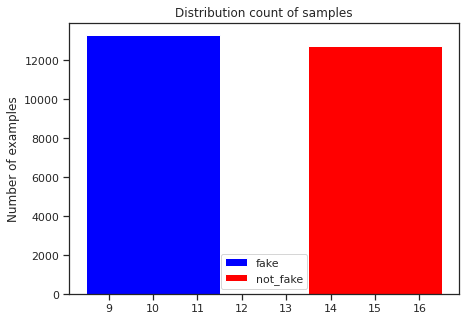

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,fake,3, label="fake", color='blue')
plt.bar(15,Not_fake,3, label="not_fake", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Distribution count of samples')
plt.show()

In [ ]:
#df_fake.apply(pd.value_counts)
ff['label'].value_counts()

1    13274
0    12726
Name: label, dtype: int64

Now, lets analyse the number of characters in each "title" samples; i.e. lets check the length of each "title" sample in the dataframe by plotting it over a distribution

In [ ]:
def length(title):    
    return len(title)

In [ ]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 0 to 5199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   25320 non-null  object
 1   text    25954 non-null  object
 2   label   26000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 812.5+ KB


In [ ]:
ff['Title_length'] = ff['title'].str.len()

In [ ]:
ff

,title,text,label,Title_length
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81.0
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,55.0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,33.0
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,63.0
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,93.0
...,...,...,...,...
5195,The Bangladeshi Traffic Jam That Never Ends - ...,Of all the dysfunctions that plague the world’...,0,64.0
5196,John Kasich Signs One Abortion Bill in Ohio bu...,WASHINGTON — Gov. John Kasich of Ohio on Tu...,1,102.0
5197,"California Today: What, Exactly, Is in Your Su...",Good morning. (Want to get California Today by...,0,71.0
5198,300 US Marines To Be Deployed To Russian Borde...,« Previous - Next » 300 US Marines To Be Deplo...,1,57.0


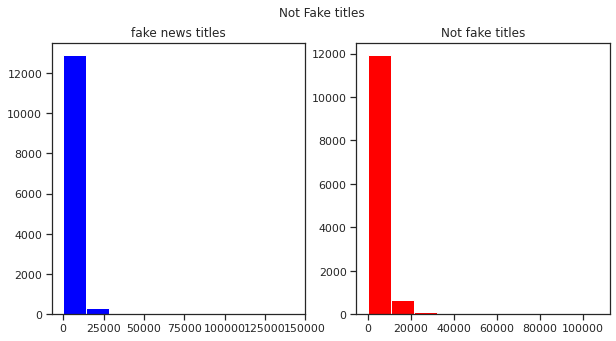

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
title_len=ff[ff['label']==1]['text'].str.len()
ax1.hist(title_len,color='blue')
ax1.set_title('fake news titles')
title_len=ff[ff['label']==0]['text'].str.len()
ax2.hist(title_len,color='red')
ax2.set_title('Not fake titles')
fig.suptitle('Not Fake titles')
plt.show()

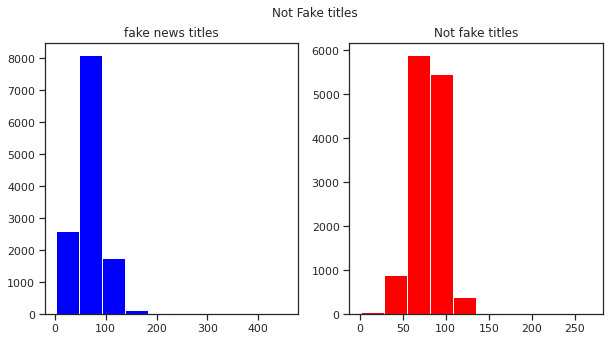

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
title_len=ff[ff['label']==1]['title'].str.len()
ax1.hist(title_len,color='blue')
ax1.set_title('fake news titles')
title_len=ff[ff['label']==0]['title'].str.len()
ax2.hist(title_len,color='red')
ax2.set_title('Not fake titles')
fig.suptitle('Not Fake titles')
plt.show()

Inference


We can infer from the above plots that the distribution that the news which was not fake had larger number of character strings; i.e. they had more length; between 650-750 characters.

**Number of words in a text**//Todo

Adding another statistical feature: "Text Length"

In [ ]:
ff['Text_length'] = ff['text'].str.len()

N-Gram Analysis

In [ ]:
def get_top_text_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Data Cleaning:
In this section, we are going to clean the tile and text string by performing the following text cleaning operations

* Lower case text
* Remove special characters
* Tokenize text into words using nltk
* Remove stop Words
* Lemmatization and Stemming

In [ ]:
ff["title"]= ff["title"].astype(str) 

In [ ]:
ff["text"]= ff["text"].astype(str) 

In [ ]:
import re
import time
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Remove this line when you want to run this for complete dataset
df_final = df_final.truncate(after=10000)

def text_cleaning(text):
  lemmatizer = WordNetLemmatizer()
  clean_text = re.sub("[^a-zA-Z]", " ", text)
  lowered_text = clean_text.lower()
  words = nltk.word_tokenize(lowered_text)
  # All stop words
  stop_words = set(nltk.corpus.stopwords.words("english"))
  filtered_words = [word for word in  words  if not word in stop_words]
  lemm_words = [lemmatizer.lemmatize(word) for word in filtered_words]
  stems = [SnowballStemmer('english').stem(word) for word in lemm_words]
  return " ".join(stems)

t1 = time.time()
ff["title"] = ff["title"].apply(text_cleaning)
ff["text"] = ff["text"].apply(text_cleaning)
t2 = time.time()
print("Time take for text cleaning with length: {} is {} mins".format(len(df_final), (t2-t1)/60))
ff.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Time take for text cleaning with length: 10001 is 0.4549216429392497 mins


,title,text,label,Title_length,Text_length
0,hous dem aid even see comey letter jason chaff...,hous dem aid even see comey letter jason chaff...,1,81.0,4930.0
1,flynn hillari clinton big woman campus breitbart,flynn hillari clinton big woman campus breitbart,0,55.0,4160.0
2,truth might get fire,truth might get fire,1,33.0,7692.0
3,civilian kill singl u airstrik identifi,civilian kill singl u airstrik identifi,1,63.0,3237.0
4,iranian woman jail fiction unpublish stori wom...,iranian woman jail fiction unpublish stori wom...,1,93.0,938.0


**TF-IDF extraction & Cosine similarity**

This weight is a product of 2 terms; the TF and IDF.

(Term FrequencyTF(t)) : (Number of times term t appears in a document) / (Total number of terms in the document)

(Inverse Term frequencyIDF(t)): log_e(Total number of documents / Number of documents with term t in it)

Also, lets calculate the cosine similarities between the Title and Text for each of the samples. This involves that we first find the strong words using TF-IDF and then perform the cosine similarity.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidfVec = TfidfVectorizer(max_features=600)
tfidf_title = tfidfVec.fit_transform(ff['title'])
tfidf_title.toarray()
tfidf_title.shape

(26000, 600)

In [ ]:
tfidf_title

<26000x600 sparse matrix of type '<class 'numpy.float64'>'
	with 121544 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_text = tfidfVec.fit_transform(ff['text'])
tfidf_text.toarray()
tfidf_text.shape

(26000, 600)

In [ ]:
tfidf_text

<26000x600 sparse matrix of type '<class 'numpy.float64'>'
	with 121544 stored elements in Compressed Sparse Row format>

In [ ]:
len(ff)
tfidf_title[0].toarray()
tfidf_text[0].toarray()
len(tfidf_title.toarray())

26000

In [ ]:
from scipy.spatial.distance import cosine
similarity_score = []
for i in range(len(ff)):
    similarity_score.append(1 - cosine(tfidf_title[i].toarray(), tfidf_text[i].toarray()))
ff['similarityScore_title_text'] = similarity_score
ff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 0 to 5199
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   title                       26000 non-null  object 
 1   text                        26000 non-null  object 
 2   label                       26000 non-null  int64  
 3   Title_length                25320 non-null  float64
 4   Text_length                 25954 non-null  float64
 5   similarityScore_title_text  25227 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, accuracy_score, \
    classification_report, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler



In [ ]:
ff = ff.drop(['title','text'], axis=1)
ff = ff.fillna(0)

y = ff['label']
X = ff.drop(['label'], axis=1)

In [ ]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X, y, test_size=0.20, random_state=100, stratify=y)
X_final_train.reset_index(drop=True, inplace=True)
X_final_test.reset_index(drop=True, inplace=True)
y_final_train.reset_index(drop=True, inplace=True)
y_final_test.reset_index(drop=True, inplace=True)

In [ ]:
classifiers = {
    "LogisticRegression": (LogisticRegression()),
    "KNearest": (KNeighborsClassifier()),
    "Support Vector Classifier": (SVC()),
    "DecisionTreeClassifier": (DecisionTreeClassifier()),
    "Naive Bayes": (GaussianNB()),
    "Random forests": (RandomForestClassifier()),
    "XGBoost Classifier": (XGBClassifier()),
    "GradientBoostingClassifier": (GradientBoostingClassifier()),
    "MLP Classifier": (MLPClassifier())
}

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

def run_all_models(folds=5):
    for classifier_name, classifier in classifiers.items():
        k_fold = StratifiedKFold(n_splits=folds, random_state=100, shuffle=True)
        cross_val_scores = []
        precision_scores = []
        recall_scores = []
        roc_auc_scores = []
        f1_scores = []
        for train_index, test_index in k_fold.split(X_final_train, y_final_train):
            X_train, X_test = pd.DataFrame(data=X_final_train, index=train_index), pd.DataFrame(data=X_final_train, index=test_index)
            y_train, y_test = pd.DataFrame(data=y_final_train, index=train_index), pd.DataFrame(data=y_final_train, index=test_index)
            model = classifier

            model.fit(X_train, y_train)
            scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=5)
            cross_val_scores.append(scores)
            y_pred = model.predict(X_test)
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            roc_auc_scores.append(roc_auc_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

        print('============================= {} ============================='.format(classifier_name))
        print('Mean cross validation score: {}'.format(np.array([cross_val_scores]).mean()))
        print('Mean precision score: {}'.format(np.array([precision_scores]).mean()))
        print('Mean Recall score: {}'.format(np.array([recall_scores]).mean()))
        print('Mean ROC-AUC score: {}'.format(np.array([roc_auc_scores]).mean()))
        print('Mean F1 score: {}'.format(np.array([f1_scores]).mean()))
        print('******* Real test dataset metrics *******')
        y_final_pred = model.predict((X_final_test))
        print('Accuracy score for the real test set:\n', accuracy_score(y_final_test, y_final_pred))
        print('confusion matrix for the real test set:\n', confusion_matrix(y_final_test, y_final_pred))
        print('Classification report for the real test set:\n', classification_report(y_final_test, y_final_pred))
        if classifier_name != 'Support Vector Classifier':
            y_final_pred_prob = model.predict_proba(X_test)
            plot_auc_roc_curve(y_test, y_final_pred_prob[:, 1], classifier_name)
            plot_precision_recall_curve(y_test, y_final_pred_prob[:, 1], classifier_name)

In [ ]:
def plot_auc_roc_curve(y_test, y_pred, name):
    fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.title('ROC for {}'.format(name))
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
def plot_precision_recall_curve(y_test, y_pred_prob, name):
    # Generate precision recall curve values: precision, recall, thresholds
    precision, recall, thresholds = precision_recall_curve(y_test.to_numpy(), y_pred_prob)

    # Plot Precision Recall curve
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    avg_precision_score = average_precision_score(y_test, y_pred_prob)
    plt.title('PRC for {} - avg precision score: {}'.format(name, str(avg_precision_score)))
    plt.show()

============================= LogisticRegression =============================
Mean cross validation score: 0.6804326923076924
Mean precision score: 0.6902864606156834
Mean Recall score: 0.6994072631114872
Mean ROC-AUC score: 0.6859676441787986
Mean F1 score: 0.6947675918428117
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6813461538461538
confusion matrix for the real test set:
 [[1659  886]
 [ 771 1884]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.68      0.65      0.67      2545
           1       0.68      0.71      0.69      2655

    accuracy                           0.68      5200
   macro avg       0.68      0.68      0.68      5200
weighted avg       0.68      0.68      0.68      5200



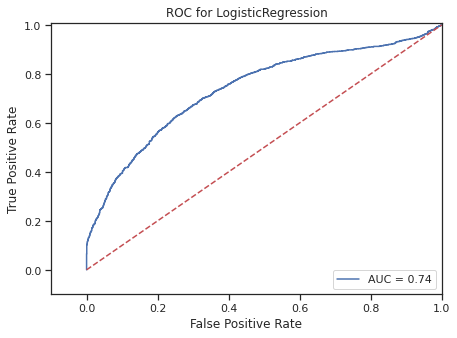

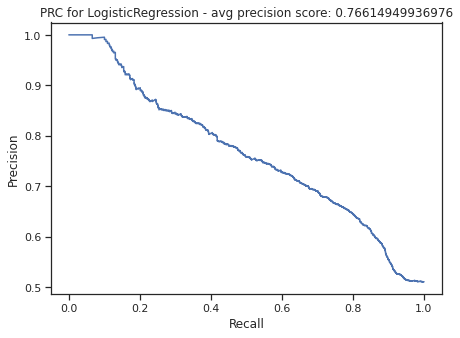

============================= KNearest =============================
Mean cross validation score: 0.6851682692307693
Mean precision score: 0.6980531387617761
Mean Recall score: 0.6793483708606216
Mean ROC-AUC score: 0.6863986097107879
Mean F1 score: 0.6885473346404349
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6873076923076923
confusion matrix for the real test set:
 [[1734  811]
 [ 815 1840]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68      2545
           1       0.69      0.69      0.69      2655

    accuracy                           0.69      5200
   macro avg       0.69      0.69      0.69      5200
weighted avg       0.69      0.69      0.69      5200



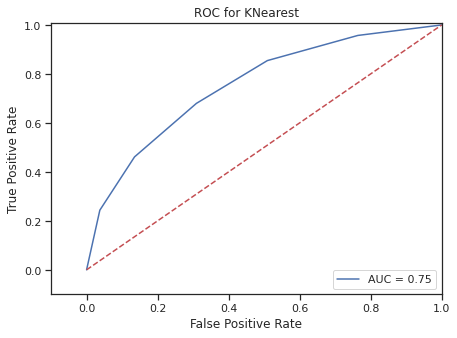

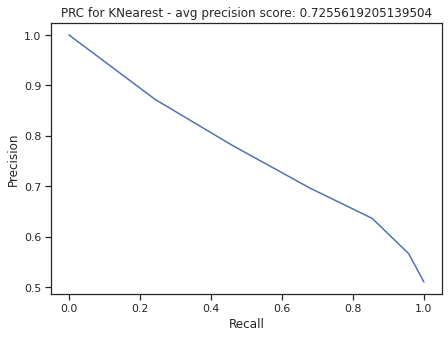

============================= Support Vector Classifier =============================
Mean cross validation score: 0.6949158653846155
Mean precision score: 0.6987743072572223
Mean Recall score: 0.711744475580429
Mean ROC-AUC score: 0.6958188347831729
Mean F1 score: 0.7051307297659857
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6873076923076923
confusion matrix for the real test set:
 [[1698  847]
 [ 779 1876]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68      2545
           1       0.69      0.71      0.70      2655

    accuracy                           0.69      5200
   macro avg       0.69      0.69      0.69      5200
weighted avg       0.69      0.69      0.69      5200

============================= DecisionTreeClassifier =============================
Mean cross validation score: 0.6573798076923077
Mean precision score: 0.6621566758804438
Me

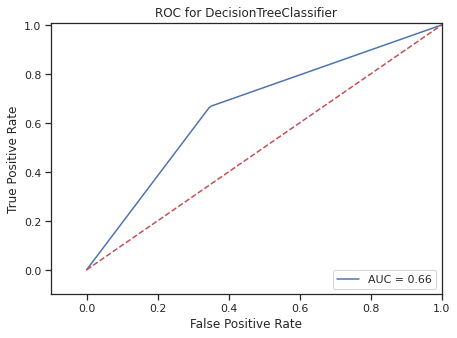

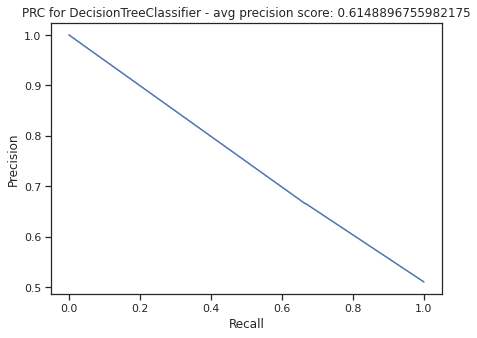

============================= Naive Bayes =============================
Mean cross validation score: 0.6430048076923077
Mean precision score: 0.8162034131560636
Mean Recall score: 0.3896777115140161
Mean ROC-AUC score: 0.6490677431477451
Mean F1 score: 0.5274837420863367
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6513461538461538
confusion matrix for the real test set:
 [[2339  206]
 [1607 1048]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.59      0.92      0.72      2545
           1       0.84      0.39      0.54      2655

    accuracy                           0.65      5200
   macro avg       0.71      0.66      0.63      5200
weighted avg       0.72      0.65      0.63      5200



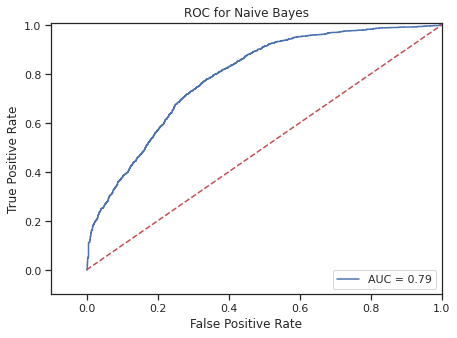

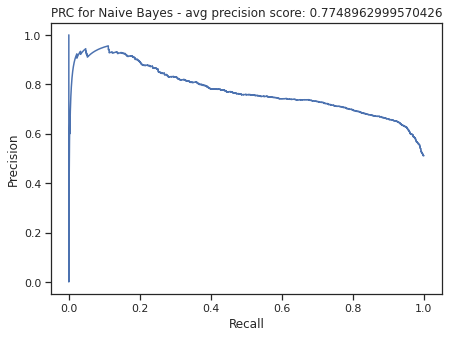

============================= Random forests =============================
Mean cross validation score: 0.6833293269230769
Mean precision score: 0.6856643238207332
Mean Recall score: 0.6842466555428706
Mean ROC-AUC score: 0.6785346640232713
Mean F1 score: 0.6849054981490313
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6848076923076923
confusion matrix for the real test set:
 [[1705  840]
 [ 799 1856]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.68      0.67      0.68      2545
           1       0.69      0.70      0.69      2655

    accuracy                           0.68      5200
   macro avg       0.68      0.68      0.68      5200
weighted avg       0.68      0.68      0.68      5200



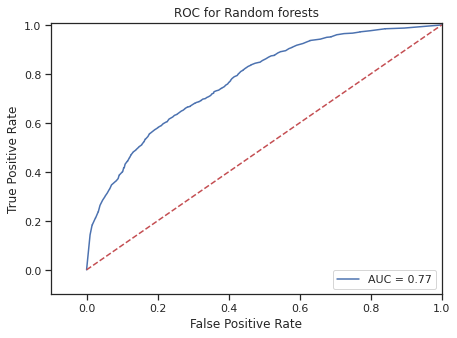

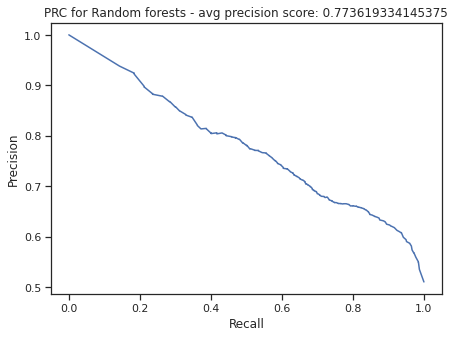

============================= XGBoost Classifier =============================
Mean cross validation score: 0.7285096153846153
Mean precision score: 0.7127823229959793
Mean Recall score: 0.7841613642351326
Mean ROC-AUC score: 0.7272635659571046
Mean F1 score: 0.7467247766330825
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.7325
confusion matrix for the real test set:
 [[1721  824]
 [ 567 2088]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.75      0.68      0.71      2545
           1       0.72      0.79      0.75      2655

    accuracy                           0.73      5200
   macro avg       0.73      0.73      0.73      5200
weighted avg       0.73      0.73      0.73      5200



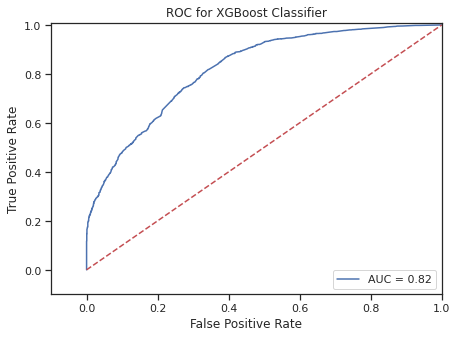

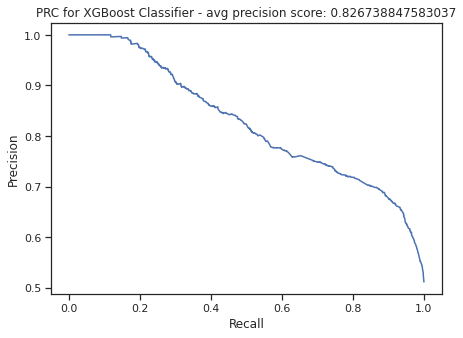

============================= GradientBoostingClassifier =============================
Mean cross validation score: 0.7283052884615385
Mean precision score: 0.7106771160835799
Mean Recall score: 0.7838795436582388
Mean ROC-AUC score: 0.7255023127590473
Mean F1 score: 0.7454335171897444
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.7321153846153846
confusion matrix for the real test set:
 [[1716  829]
 [ 564 2091]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71      2545
           1       0.72      0.79      0.75      2655

    accuracy                           0.73      5200
   macro avg       0.73      0.73      0.73      5200
weighted avg       0.73      0.73      0.73      5200



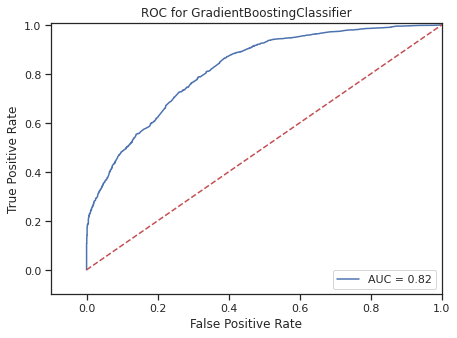

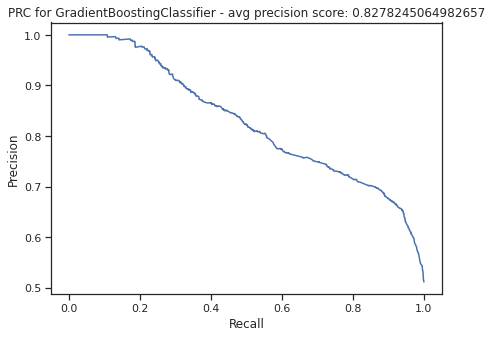

============================= MLP Classifier =============================
Mean cross validation score: 0.6402884615384614
Mean precision score: 0.6612472470922072
Mean Recall score: 0.7006981645736367
Mean ROC-AUC score: 0.6081160032856677
Mean F1 score: 0.6336646653276934
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.6369230769230769
confusion matrix for the real test set:
 [[2239  306]
 [1582 1073]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       0.59      0.88      0.70      2545
           1       0.78      0.40      0.53      2655

    accuracy                           0.64      5200
   macro avg       0.68      0.64      0.62      5200
weighted avg       0.68      0.64      0.62      5200



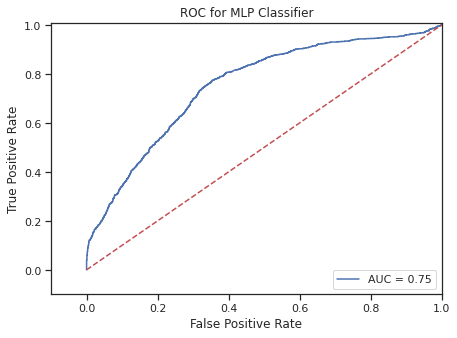

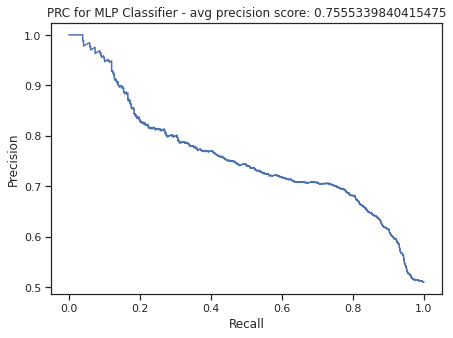

In [ ]:
run_all_models()